In [1]:
import time
import os, scipy
import torch   
import scipy.sparse as sp 
import numpy as np  
import torch.nn.functional as F 
import pickle
import numpy.random as random
import matplotlib.pyplot as plt 
from math import *
from numpy import transpose,matrix,exp,conj
from numpy.linalg import inv 
from util_final import * 
import torch.nn as nn
from load_data import *
from PPGN import *

In [2]:
if True: 
    np_load_old = np.load
    np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k) 
    data = np.load('./data/info.npy')
    bus_dict = data[0]  
    bus_phase= data[1] 
    load_phase= data[3]  
    fault_bus_list = sorted(list(bus_dict.keys())) 
    bus_to_index = dict((bus, index) for index, bus in enumerate(fault_bus_list))#  
    index_to_bus = dict((index, bus) for bus, index in bus_to_index.items())
    singlePhaseBus = [bus for bus, phases in bus_phase.items() if len(phases) == 1]
    singlePhaseIndex = [bus_to_index[i] for i in singlePhaseBus] 

In [8]:
# parameters  
dropout = 0
dropout_outlayer = 0 
root = "./data/" 
num_node = 128   
dim_input = 6
num_labelper = 33
agg_func = "MEAN"
epochs =  100 
b_sz = 32
global seed
seed = 842 
learn_method = 'sup' 
max_vali_f1 = 0  
hidden_emb_size = [32,32,32] 
num_layers = len(hidden_emb_size) 
dataSet = 'loc'
ds = dataSet
device = torch.device("cuda" if  torch.cuda.is_available() else "cpu") 
random.seed( seed)
np.random.seed( seed)
torch.manual_seed( seed)
torch.cuda.manual_seed_all( seed)
lr = 0.001
weight_name = 'A_short' 
k=3  
measured_index =[73, 94, 105, 118, 72, 79, 24, 41, 69, 90, 84, 78, 122, 49, 66, 104, 109, 10, 36, 31, 85]
dataC = dataCenter(num_labelper,seed, measured_index)   
A, prob_A = select_A_prob(k, 'A_short') # option 1: 'A_short': using shortest path 'A_adam': using admittance matrix
nodes_layers  = dic_nodes_neib(num_layers,A,prob_A )   
modelname =   str(num_labelper) + '_all_'  + '.pkl'
saveroot = "./"
savepath = os.path.join(saveroot, modelname ) 
savebest = os.path.join(os.path.join(saveroot, '00_saved_final'), learn_method + '_'+ str(num_labelper) + '_all_' +str(len(measured_index)) + '.pkl') 
retrain =     False  
#load data
features, labels, ind_train ,  ind_test,    neib_observ,ind_labels, ind_measured= load_all_types( num_labelper , measured_index,seed = seed )
with open(os.path.join(root, 'neib.pickle'), 'rb') as f:
    dic = pickle.load(f)
neib  = dic['neib']

In [9]:
#Establish PPGN
graph_stageI = GraphSage(num_layers, dim_input,hidden_emb_size  ,   A, prob_A, dropout = dropout ,device = device,    agg_method= agg_func  )
graph_stageI.to(device) 
classification = Outlayer_fully( hidden_emb_size[-1],  num_node,  dropout = dropout_outlayer) 
classification.to(device)
models = [graph_stageI, classification]
params = []
for model in models:
    for param in model.parameters():
        if param.requires_grad:
            params.append(param)
optimizer = torch.optim.Adam(params, lr = lr, weight_decay = 5e-3)  
if retrain:
    models, optimizer, start_epoch = load_checkpoint(models, optimizer, savepath) 
    graph_stageI, classification  = models[0], models[1]

----------------------EPOCH 0-----------------------
Update the Whole Graph
 Step [0/189], Loss: 4.8300, Dealed Nodes [32/6039] 
 Step [5/189], Loss: 4.7475, Dealed Nodes [192/6039] 
 Step [10/189], Loss: 4.6088, Dealed Nodes [352/6039] 
 Step [15/189], Loss: 4.3030, Dealed Nodes [512/6039] 
 Step [20/189], Loss: 4.2268, Dealed Nodes [672/6039] 
 Step [25/189], Loss: 4.4376, Dealed Nodes [832/6039] 
 Step [30/189], Loss: 4.0127, Dealed Nodes [992/6039] 
 Step [35/189], Loss: 4.1392, Dealed Nodes [1152/6039] 
 Step [40/189], Loss: 3.9694, Dealed Nodes [1312/6039] 
 Step [45/189], Loss: 3.9954, Dealed Nodes [1472/6039] 
 Step [50/189], Loss: 3.9567, Dealed Nodes [1632/6039] 
 Step [55/189], Loss: 3.7389, Dealed Nodes [1792/6039] 
 Step [60/189], Loss: 3.7341, Dealed Nodes [1952/6039] 
 Step [65/189], Loss: 3.5478, Dealed Nodes [2112/6039] 
 Step [70/189], Loss: 3.8444, Dealed Nodes [2272/6039] 
 Step [75/189], Loss: 3.3872, Dealed Nodes [2432/6039] 
 Step [80/189], Loss: 3.3534, Dealed N

 Step [120/189], Loss: 1.7223, Dealed Nodes [3872/6039] 
 Step [125/189], Loss: 1.6949, Dealed Nodes [4032/6039] 
 Step [130/189], Loss: 1.5982, Dealed Nodes [4192/6039] 
 Step [135/189], Loss: 2.1091, Dealed Nodes [4352/6039] 
 Step [140/189], Loss: 1.4873, Dealed Nodes [4512/6039] 
 Step [145/189], Loss: 1.6022, Dealed Nodes [4672/6039] 
 Step [150/189], Loss: 1.5072, Dealed Nodes [4832/6039] 
 Step [155/189], Loss: 1.4414, Dealed Nodes [4992/6039] 
 Step [160/189], Loss: 1.7450, Dealed Nodes [5152/6039] 
 Step [165/189], Loss: 1.4546, Dealed Nodes [5312/6039] 
 Step [170/189], Loss: 1.6409, Dealed Nodes [5472/6039] 
 Step [175/189], Loss: 1.6453, Dealed Nodes [5632/6039] 
 Step [180/189], Loss: 1.4887, Dealed Nodes [5792/6039] 
 Step [185/189], Loss: 1.9643, Dealed Nodes [5952/6039] 
Validation F1: 0.4293300653594771
Test F1: 0.4693627450980392
----------------------EPOCH 4-----------------------
Update the Whole Graph
 Step [0/189], Loss: 1.4107, Dealed Nodes [32/6039] 
 Step [5/18

 Step [40/189], Loss: 1.0951, Dealed Nodes [1312/6039] 
 Step [45/189], Loss: 1.4916, Dealed Nodes [1472/6039] 
 Step [50/189], Loss: 1.5664, Dealed Nodes [1632/6039] 
 Step [55/189], Loss: 1.2349, Dealed Nodes [1792/6039] 
 Step [60/189], Loss: 1.2988, Dealed Nodes [1952/6039] 
 Step [65/189], Loss: 1.2169, Dealed Nodes [2112/6039] 
 Step [70/189], Loss: 1.2670, Dealed Nodes [2272/6039] 
 Step [75/189], Loss: 1.1711, Dealed Nodes [2432/6039] 
 Step [80/189], Loss: 1.0484, Dealed Nodes [2592/6039] 
 Step [85/189], Loss: 1.1303, Dealed Nodes [2752/6039] 
 Step [90/189], Loss: 1.1202, Dealed Nodes [2912/6039] 
 Step [95/189], Loss: 1.1040, Dealed Nodes [3072/6039] 
 Step [100/189], Loss: 0.9422, Dealed Nodes [3232/6039] 
 Step [105/189], Loss: 1.2170, Dealed Nodes [3392/6039] 
 Step [110/189], Loss: 0.9972, Dealed Nodes [3552/6039] 
 Step [115/189], Loss: 1.0990, Dealed Nodes [3712/6039] 
 Step [120/189], Loss: 1.1241, Dealed Nodes [3872/6039] 
 Step [125/189], Loss: 1.2366, Dealed Nodes

Embeddings loaded.
Epoch [1/10], Step [60/61], Loss: 0.3884, Dealed Nodes [6039/6039]
Epoch [2/10], Step [60/61], Loss: 0.6863, Dealed Nodes [6039/6039]
Epoch [3/10], Step [60/61], Loss: 0.5330, Dealed Nodes [6039/6039]
Epoch [4/10], Step [60/61], Loss: 0.5150, Dealed Nodes [6039/6039]
Epoch [5/10], Step [60/61], Loss: 0.3645, Dealed Nodes [6039/6039]
Epoch [6/10], Step [60/61], Loss: 0.4812, Dealed Nodes [6039/6039]
Epoch [7/10], Step [60/61], Loss: 0.5078, Dealed Nodes [6039/6039]
Epoch [8/10], Step [60/61], Loss: 0.5474, Dealed Nodes [6039/6039]
Epoch [9/10], Step [60/61], Loss: 0.5299, Dealed Nodes [6039/6039]
Epoch [10/10], Step [60/61], Loss: 0.4777, Dealed Nodes [6039/6039]
Validation F1: 0.8288398692810458
Test F1: 0.8325980392156862
----------------------EPOCH 13-----------------------
Update only the fully connect layers
Training Classification ...
Loading embeddings from trained GraphSAGE model.
Embeddings loaded.
Epoch [1/10], Step [60/61], Loss: 0.3501, Dealed Nodes [6039/

 Step [95/189], Loss: 1.4722, Dealed Nodes [3072/6039] 
 Step [100/189], Loss: 0.6626, Dealed Nodes [3232/6039] 
 Step [105/189], Loss: 0.6449, Dealed Nodes [3392/6039] 
 Step [110/189], Loss: 1.1113, Dealed Nodes [3552/6039] 
 Step [115/189], Loss: 1.8380, Dealed Nodes [3712/6039] 
 Step [120/189], Loss: 0.6104, Dealed Nodes [3872/6039] 
 Step [125/189], Loss: 0.5787, Dealed Nodes [4032/6039] 
 Step [130/189], Loss: 0.9237, Dealed Nodes [4192/6039] 
 Step [135/189], Loss: 0.7467, Dealed Nodes [4352/6039] 
 Step [140/189], Loss: 1.0808, Dealed Nodes [4512/6039] 
 Step [145/189], Loss: 0.8159, Dealed Nodes [4672/6039] 
 Step [150/189], Loss: 1.2464, Dealed Nodes [4832/6039] 
 Step [155/189], Loss: 0.7843, Dealed Nodes [4992/6039] 
 Step [160/189], Loss: 0.8301, Dealed Nodes [5152/6039] 
 Step [165/189], Loss: 0.9705, Dealed Nodes [5312/6039] 
 Step [170/189], Loss: 1.2615, Dealed Nodes [5472/6039] 
 Step [175/189], Loss: 0.9035, Dealed Nodes [5632/6039] 
 Step [180/189], Loss: 0.4873, D

 Step [25/189], Loss: 0.9004, Dealed Nodes [832/6039] 
 Step [30/189], Loss: 0.6632, Dealed Nodes [992/6039] 
 Step [35/189], Loss: 0.7014, Dealed Nodes [1152/6039] 
 Step [40/189], Loss: 0.8261, Dealed Nodes [1312/6039] 
 Step [45/189], Loss: 0.7189, Dealed Nodes [1472/6039] 
 Step [50/189], Loss: 0.6940, Dealed Nodes [1632/6039] 
 Step [55/189], Loss: 0.6589, Dealed Nodes [1792/6039] 
 Step [60/189], Loss: 0.7757, Dealed Nodes [1952/6039] 
 Step [65/189], Loss: 0.5801, Dealed Nodes [2112/6039] 
 Step [70/189], Loss: 0.7284, Dealed Nodes [2272/6039] 
 Step [75/189], Loss: 0.6862, Dealed Nodes [2432/6039] 
 Step [80/189], Loss: 0.6105, Dealed Nodes [2592/6039] 
 Step [85/189], Loss: 1.2089, Dealed Nodes [2752/6039] 
 Step [90/189], Loss: 0.5593, Dealed Nodes [2912/6039] 
 Step [95/189], Loss: 0.6801, Dealed Nodes [3072/6039] 
 Step [100/189], Loss: 0.5892, Dealed Nodes [3232/6039] 
 Step [105/189], Loss: 0.7557, Dealed Nodes [3392/6039] 
 Step [110/189], Loss: 1.0314, Dealed Nodes [355

 Step [155/189], Loss: 0.6442, Dealed Nodes [4992/6039] 
 Step [160/189], Loss: 0.9238, Dealed Nodes [5152/6039] 
 Step [165/189], Loss: 0.4916, Dealed Nodes [5312/6039] 
 Step [170/189], Loss: 0.6887, Dealed Nodes [5472/6039] 
 Step [175/189], Loss: 0.7942, Dealed Nodes [5632/6039] 
 Step [180/189], Loss: 0.5452, Dealed Nodes [5792/6039] 
 Step [185/189], Loss: 0.8402, Dealed Nodes [5952/6039] 
Validation F1: 0.6959967320261438
----------------------EPOCH 28-----------------------
Update the Whole Graph
 Step [0/189], Loss: 0.6909, Dealed Nodes [32/6039] 
 Step [5/189], Loss: 0.6209, Dealed Nodes [192/6039] 
 Step [10/189], Loss: 0.9299, Dealed Nodes [352/6039] 
 Step [15/189], Loss: 0.7320, Dealed Nodes [512/6039] 
 Step [20/189], Loss: 0.8206, Dealed Nodes [672/6039] 
 Step [25/189], Loss: 0.7253, Dealed Nodes [832/6039] 
 Step [30/189], Loss: 0.6827, Dealed Nodes [992/6039] 
 Step [35/189], Loss: 0.5741, Dealed Nodes [1152/6039] 
 Step [40/189], Loss: 0.7242, Dealed Nodes [1312/603

Epoch [7/10], Step [60/61], Loss: 0.2896, Dealed Nodes [6039/6039]
Epoch [8/10], Step [60/61], Loss: 0.4164, Dealed Nodes [6039/6039]
Epoch [9/10], Step [60/61], Loss: 0.3785, Dealed Nodes [6039/6039]
Epoch [10/10], Step [60/61], Loss: 0.2678, Dealed Nodes [6039/6039]
Validation F1: 0.9150326797385621
Test F1: 0.9330882352941177
----------------------EPOCH 34-----------------------
Update only the fully connect layers
Training Classification ...
Loading embeddings from trained GraphSAGE model.
Embeddings loaded.
Epoch [1/10], Step [60/61], Loss: 0.2429, Dealed Nodes [6039/6039]
Epoch [2/10], Step [60/61], Loss: 0.3326, Dealed Nodes [6039/6039]
Epoch [3/10], Step [60/61], Loss: 0.3752, Dealed Nodes [6039/6039]
Epoch [4/10], Step [60/61], Loss: 0.4966, Dealed Nodes [6039/6039]
Epoch [5/10], Step [60/61], Loss: 0.4193, Dealed Nodes [6039/6039]
Epoch [6/10], Step [60/61], Loss: 0.2680, Dealed Nodes [6039/6039]
Epoch [7/10], Step [60/61], Loss: 0.2742, Dealed Nodes [6039/6039]
Epoch [8/10],

 Step [15/189], Loss: 0.4080, Dealed Nodes [512/6039] 
 Step [20/189], Loss: 0.7378, Dealed Nodes [672/6039] 
 Step [25/189], Loss: 0.5780, Dealed Nodes [832/6039] 
 Step [30/189], Loss: 0.2549, Dealed Nodes [992/6039] 
 Step [35/189], Loss: 0.4885, Dealed Nodes [1152/6039] 
 Step [40/189], Loss: 0.5402, Dealed Nodes [1312/6039] 
 Step [45/189], Loss: 0.3377, Dealed Nodes [1472/6039] 
 Step [50/189], Loss: 0.4407, Dealed Nodes [1632/6039] 
 Step [55/189], Loss: 0.8482, Dealed Nodes [1792/6039] 
 Step [60/189], Loss: 0.4701, Dealed Nodes [1952/6039] 
 Step [65/189], Loss: 0.4855, Dealed Nodes [2112/6039] 
 Step [70/189], Loss: 1.2720, Dealed Nodes [2272/6039] 
 Step [75/189], Loss: 0.5719, Dealed Nodes [2432/6039] 
 Step [80/189], Loss: 0.2499, Dealed Nodes [2592/6039] 
 Step [85/189], Loss: 0.2813, Dealed Nodes [2752/6039] 
 Step [90/189], Loss: 0.3057, Dealed Nodes [2912/6039] 
 Step [95/189], Loss: 0.2095, Dealed Nodes [3072/6039] 
 Step [100/189], Loss: 0.5101, Dealed Nodes [3232/60

 Step [145/189], Loss: 0.5918, Dealed Nodes [4672/6039] 
 Step [150/189], Loss: 1.0946, Dealed Nodes [4832/6039] 
 Step [155/189], Loss: 0.5047, Dealed Nodes [4992/6039] 
 Step [160/189], Loss: 0.5415, Dealed Nodes [5152/6039] 
 Step [165/189], Loss: 0.4431, Dealed Nodes [5312/6039] 
 Step [170/189], Loss: 0.6791, Dealed Nodes [5472/6039] 
 Step [175/189], Loss: 0.5656, Dealed Nodes [5632/6039] 
 Step [180/189], Loss: 0.7260, Dealed Nodes [5792/6039] 
 Step [185/189], Loss: 1.0736, Dealed Nodes [5952/6039] 
Validation F1: 0.755065359477124
----------------------EPOCH 45-----------------------
Update the Whole Graph
 Step [0/189], Loss: 0.7658, Dealed Nodes [32/6039] 
 Step [5/189], Loss: 0.7604, Dealed Nodes [192/6039] 
 Step [10/189], Loss: 0.5719, Dealed Nodes [352/6039] 
 Step [15/189], Loss: 0.5999, Dealed Nodes [512/6039] 
 Step [20/189], Loss: 0.6092, Dealed Nodes [672/6039] 
 Step [25/189], Loss: 1.0886, Dealed Nodes [832/6039] 
 Step [30/189], Loss: 0.5563, Dealed Nodes [992/60

 Step [75/189], Loss: 0.6631, Dealed Nodes [2432/6039] 
 Step [80/189], Loss: 0.5432, Dealed Nodes [2592/6039] 
 Step [85/189], Loss: 0.3480, Dealed Nodes [2752/6039] 
 Step [90/189], Loss: 0.4801, Dealed Nodes [2912/6039] 
 Step [95/189], Loss: 0.5514, Dealed Nodes [3072/6039] 
 Step [100/189], Loss: 0.5019, Dealed Nodes [3232/6039] 
 Step [105/189], Loss: 0.5439, Dealed Nodes [3392/6039] 
 Step [110/189], Loss: 0.5866, Dealed Nodes [3552/6039] 
 Step [115/189], Loss: 0.5476, Dealed Nodes [3712/6039] 
 Step [120/189], Loss: 0.8954, Dealed Nodes [3872/6039] 
 Step [125/189], Loss: 0.4869, Dealed Nodes [4032/6039] 
 Step [130/189], Loss: 0.5918, Dealed Nodes [4192/6039] 
 Step [135/189], Loss: 0.4680, Dealed Nodes [4352/6039] 
 Step [140/189], Loss: 0.3828, Dealed Nodes [4512/6039] 
 Step [145/189], Loss: 0.5026, Dealed Nodes [4672/6039] 
 Step [150/189], Loss: 0.5113, Dealed Nodes [4832/6039] 
 Step [155/189], Loss: 0.6860, Dealed Nodes [4992/6039] 
 Step [160/189], Loss: 0.7583, Deale

Embeddings loaded.
Epoch [1/10], Step [60/61], Loss: 0.2658, Dealed Nodes [6039/6039]
Epoch [2/10], Step [60/61], Loss: 0.2421, Dealed Nodes [6039/6039]
Epoch [3/10], Step [60/61], Loss: 0.4427, Dealed Nodes [6039/6039]
Epoch [4/10], Step [60/61], Loss: 0.3342, Dealed Nodes [6039/6039]
Epoch [5/10], Step [60/61], Loss: 0.2903, Dealed Nodes [6039/6039]
Epoch [6/10], Step [60/61], Loss: 0.3632, Dealed Nodes [6039/6039]
Epoch [7/10], Step [60/61], Loss: 0.2551, Dealed Nodes [6039/6039]
Epoch [8/10], Step [60/61], Loss: 0.1901, Dealed Nodes [6039/6039]
Epoch [9/10], Step [60/61], Loss: 0.2167, Dealed Nodes [6039/6039]
Epoch [10/10], Step [60/61], Loss: 0.3491, Dealed Nodes [6039/6039]
Validation F1: 0.9252450980392157
----------------------EPOCH 56-----------------------
Update only the fully connect layers
Training Classification ...
Loading embeddings from trained GraphSAGE model.
Embeddings loaded.
Epoch [1/10], Step [60/61], Loss: 0.2355, Dealed Nodes [6039/6039]
Epoch [2/10], Step [60

 Step [140/189], Loss: 0.3805, Dealed Nodes [4512/6039] 
 Step [145/189], Loss: 0.6587, Dealed Nodes [4672/6039] 
 Step [150/189], Loss: 0.3283, Dealed Nodes [4832/6039] 
 Step [155/189], Loss: 0.5019, Dealed Nodes [4992/6039] 
 Step [160/189], Loss: 0.2714, Dealed Nodes [5152/6039] 
 Step [165/189], Loss: 0.5285, Dealed Nodes [5312/6039] 
 Step [170/189], Loss: 0.4539, Dealed Nodes [5472/6039] 
 Step [175/189], Loss: 0.3522, Dealed Nodes [5632/6039] 
 Step [180/189], Loss: 0.6853, Dealed Nodes [5792/6039] 
 Step [185/189], Loss: 0.4198, Dealed Nodes [5952/6039] 
Validation F1: 0.9165032679738562
----------------------EPOCH 62-----------------------
Update the Whole Graph
 Step [0/189], Loss: 0.3774, Dealed Nodes [32/6039] 
 Step [5/189], Loss: 0.5553, Dealed Nodes [192/6039] 
 Step [10/189], Loss: 0.3662, Dealed Nodes [352/6039] 
 Step [15/189], Loss: 0.2939, Dealed Nodes [512/6039] 
 Step [20/189], Loss: 0.3317, Dealed Nodes [672/6039] 
 Step [25/189], Loss: 0.3571, Dealed Nodes [832

 Step [70/189], Loss: 0.4096, Dealed Nodes [2272/6039] 
 Step [75/189], Loss: 0.5505, Dealed Nodes [2432/6039] 
 Step [80/189], Loss: 0.4266, Dealed Nodes [2592/6039] 
 Step [85/189], Loss: 0.5825, Dealed Nodes [2752/6039] 
 Step [90/189], Loss: 0.5311, Dealed Nodes [2912/6039] 
 Step [95/189], Loss: 0.5396, Dealed Nodes [3072/6039] 
 Step [100/189], Loss: 0.3697, Dealed Nodes [3232/6039] 
 Step [105/189], Loss: 0.4954, Dealed Nodes [3392/6039] 
 Step [110/189], Loss: 0.7352, Dealed Nodes [3552/6039] 
 Step [115/189], Loss: 0.3398, Dealed Nodes [3712/6039] 
 Step [120/189], Loss: 0.4398, Dealed Nodes [3872/6039] 
 Step [125/189], Loss: 0.5312, Dealed Nodes [4032/6039] 
 Step [130/189], Loss: 0.5296, Dealed Nodes [4192/6039] 
 Step [135/189], Loss: 0.5771, Dealed Nodes [4352/6039] 
 Step [140/189], Loss: 0.6118, Dealed Nodes [4512/6039] 
 Step [145/189], Loss: 0.4028, Dealed Nodes [4672/6039] 
 Step [150/189], Loss: 0.5170, Dealed Nodes [4832/6039] 
 Step [155/189], Loss: 0.6438, Dealed

 Step [5/189], Loss: 0.4149, Dealed Nodes [192/6039] 
 Step [10/189], Loss: 0.7823, Dealed Nodes [352/6039] 
 Step [15/189], Loss: 0.6642, Dealed Nodes [512/6039] 
 Step [20/189], Loss: 0.4029, Dealed Nodes [672/6039] 
 Step [25/189], Loss: 0.5311, Dealed Nodes [832/6039] 
 Step [30/189], Loss: 0.6355, Dealed Nodes [992/6039] 
 Step [35/189], Loss: 0.6471, Dealed Nodes [1152/6039] 
 Step [40/189], Loss: 0.5509, Dealed Nodes [1312/6039] 
 Step [45/189], Loss: 0.5394, Dealed Nodes [1472/6039] 
 Step [50/189], Loss: 0.3843, Dealed Nodes [1632/6039] 
 Step [55/189], Loss: 0.5317, Dealed Nodes [1792/6039] 
 Step [60/189], Loss: 0.5587, Dealed Nodes [1952/6039] 
 Step [65/189], Loss: 0.4523, Dealed Nodes [2112/6039] 
 Step [70/189], Loss: 0.6994, Dealed Nodes [2272/6039] 
 Step [75/189], Loss: 0.5133, Dealed Nodes [2432/6039] 
 Step [80/189], Loss: 0.5709, Dealed Nodes [2592/6039] 
 Step [85/189], Loss: 0.5909, Dealed Nodes [2752/6039] 
 Step [90/189], Loss: 0.8567, Dealed Nodes [2912/6039] 

Epoch [9/10], Step [60/61], Loss: 0.8965, Dealed Nodes [6039/6039]
Epoch [10/10], Step [60/61], Loss: 0.2380, Dealed Nodes [6039/6039]
Validation F1: 0.9070261437908497
----------------------EPOCH 77-----------------------
Update only the fully connect layers
Training Classification ...
Loading embeddings from trained GraphSAGE model.
Embeddings loaded.
Epoch [1/10], Step [60/61], Loss: 0.2295, Dealed Nodes [6039/6039]
Epoch [2/10], Step [60/61], Loss: 0.1739, Dealed Nodes [6039/6039]
Epoch [3/10], Step [60/61], Loss: 0.2326, Dealed Nodes [6039/6039]
Epoch [4/10], Step [60/61], Loss: 0.1866, Dealed Nodes [6039/6039]
Epoch [5/10], Step [60/61], Loss: 0.2061, Dealed Nodes [6039/6039]
Epoch [6/10], Step [60/61], Loss: 0.2508, Dealed Nodes [6039/6039]
Epoch [7/10], Step [60/61], Loss: 0.3294, Dealed Nodes [6039/6039]
Epoch [8/10], Step [60/61], Loss: 0.2715, Dealed Nodes [6039/6039]
Epoch [9/10], Step [60/61], Loss: 0.2412, Dealed Nodes [6039/6039]
Epoch [10/10], Step [60/61], Loss: 0.1879

 Step [75/189], Loss: 0.3610, Dealed Nodes [2432/6039] 
 Step [80/189], Loss: 0.2199, Dealed Nodes [2592/6039] 
 Step [85/189], Loss: 0.5500, Dealed Nodes [2752/6039] 
 Step [90/189], Loss: 0.9483, Dealed Nodes [2912/6039] 
 Step [95/189], Loss: 0.9722, Dealed Nodes [3072/6039] 
 Step [100/189], Loss: 0.4847, Dealed Nodes [3232/6039] 
 Step [105/189], Loss: 0.4965, Dealed Nodes [3392/6039] 
 Step [110/189], Loss: 0.5566, Dealed Nodes [3552/6039] 
 Step [115/189], Loss: 0.2817, Dealed Nodes [3712/6039] 
 Step [120/189], Loss: 0.9814, Dealed Nodes [3872/6039] 
 Step [125/189], Loss: 0.5354, Dealed Nodes [4032/6039] 
 Step [130/189], Loss: 0.3437, Dealed Nodes [4192/6039] 
 Step [135/189], Loss: 0.3916, Dealed Nodes [4352/6039] 
 Step [140/189], Loss: 0.2208, Dealed Nodes [4512/6039] 
 Step [145/189], Loss: 0.3383, Dealed Nodes [4672/6039] 
 Step [150/189], Loss: 0.2537, Dealed Nodes [4832/6039] 
 Step [155/189], Loss: 0.3201, Dealed Nodes [4992/6039] 
 Step [160/189], Loss: 0.4110, Deale

 Step [5/189], Loss: 0.5311, Dealed Nodes [192/6039] 
 Step [10/189], Loss: 0.3410, Dealed Nodes [352/6039] 
 Step [15/189], Loss: 0.3480, Dealed Nodes [512/6039] 
 Step [20/189], Loss: 0.4553, Dealed Nodes [672/6039] 
 Step [25/189], Loss: 0.4173, Dealed Nodes [832/6039] 
 Step [30/189], Loss: 0.4042, Dealed Nodes [992/6039] 
 Step [35/189], Loss: 0.4360, Dealed Nodes [1152/6039] 
 Step [40/189], Loss: 0.3835, Dealed Nodes [1312/6039] 
 Step [45/189], Loss: 0.5385, Dealed Nodes [1472/6039] 
 Step [50/189], Loss: 0.5002, Dealed Nodes [1632/6039] 
 Step [55/189], Loss: 0.5393, Dealed Nodes [1792/6039] 
 Step [60/189], Loss: 0.4794, Dealed Nodes [1952/6039] 
 Step [65/189], Loss: 0.3144, Dealed Nodes [2112/6039] 
 Step [70/189], Loss: 0.5055, Dealed Nodes [2272/6039] 
 Step [75/189], Loss: 0.3153, Dealed Nodes [2432/6039] 
 Step [80/189], Loss: 0.6537, Dealed Nodes [2592/6039] 
 Step [85/189], Loss: 0.7094, Dealed Nodes [2752/6039] 
 Step [90/189], Loss: 0.7292, Dealed Nodes [2912/6039] 

 Step [135/189], Loss: 0.6138, Dealed Nodes [4352/6039] 
 Step [140/189], Loss: 0.5184, Dealed Nodes [4512/6039] 
 Step [145/189], Loss: 0.3374, Dealed Nodes [4672/6039] 
 Step [150/189], Loss: 0.5591, Dealed Nodes [4832/6039] 
 Step [155/189], Loss: 0.5662, Dealed Nodes [4992/6039] 
 Step [160/189], Loss: 0.6777, Dealed Nodes [5152/6039] 
 Step [165/189], Loss: 0.5278, Dealed Nodes [5312/6039] 
 Step [170/189], Loss: 0.3564, Dealed Nodes [5472/6039] 
 Step [175/189], Loss: 0.6389, Dealed Nodes [5632/6039] 
 Step [180/189], Loss: 0.3602, Dealed Nodes [5792/6039] 
 Step [185/189], Loss: 0.4494, Dealed Nodes [5952/6039] 
Validation F1: 0.7858660130718954
----------------------EPOCH 90-----------------------
Update only the fully connect layers
Training Classification ...
Loading embeddings from trained GraphSAGE model.
Embeddings loaded.
Epoch [1/10], Step [60/61], Loss: 0.5063, Dealed Nodes [6039/6039]
Epoch [2/10], Step [60/61], Loss: 0.4958, Dealed Nodes [6039/6039]
Epoch [3/10], Step

Epoch [5/10], Step [60/61], Loss: 0.7882, Dealed Nodes [6039/6039]
Epoch [6/10], Step [60/61], Loss: 0.2443, Dealed Nodes [6039/6039]
Epoch [7/10], Step [60/61], Loss: 0.2606, Dealed Nodes [6039/6039]
Epoch [8/10], Step [60/61], Loss: 0.1996, Dealed Nodes [6039/6039]
Epoch [9/10], Step [60/61], Loss: 0.2143, Dealed Nodes [6039/6039]
Epoch [10/10], Step [60/61], Loss: 0.1864, Dealed Nodes [6039/6039]
Validation F1: 0.9308823529411766
----------------------EPOCH 99-----------------------
Update only the fully connect layers
Training Classification ...
Loading embeddings from trained GraphSAGE model.
Embeddings loaded.
Epoch [1/10], Step [60/61], Loss: 0.2586, Dealed Nodes [6039/6039]
Epoch [2/10], Step [60/61], Loss: 0.2557, Dealed Nodes [6039/6039]
Epoch [3/10], Step [60/61], Loss: 0.3474, Dealed Nodes [6039/6039]
Epoch [4/10], Step [60/61], Loss: 0.2373, Dealed Nodes [6039/6039]
Epoch [5/10], Step [60/61], Loss: 0.1741, Dealed Nodes [6039/6039]
Epoch [6/10], Step [60/61], Loss: 0.4033,

 Step [5/189], Loss: 0.3799, Dealed Nodes [192/6039] 
 Step [10/189], Loss: 0.3313, Dealed Nodes [352/6039] 
 Step [15/189], Loss: 0.5982, Dealed Nodes [512/6039] 
 Step [20/189], Loss: 0.4629, Dealed Nodes [672/6039] 
 Step [25/189], Loss: 0.3396, Dealed Nodes [832/6039] 
 Step [30/189], Loss: 0.3775, Dealed Nodes [992/6039] 
 Step [35/189], Loss: 0.8826, Dealed Nodes [1152/6039] 
 Step [40/189], Loss: 0.2253, Dealed Nodes [1312/6039] 
 Step [45/189], Loss: 0.8291, Dealed Nodes [1472/6039] 
 Step [50/189], Loss: 0.3188, Dealed Nodes [1632/6039] 
 Step [55/189], Loss: 0.3897, Dealed Nodes [1792/6039] 
 Step [60/189], Loss: 0.4027, Dealed Nodes [1952/6039] 
 Step [65/189], Loss: 0.2936, Dealed Nodes [2112/6039] 
 Step [70/189], Loss: 0.4560, Dealed Nodes [2272/6039] 
 Step [75/189], Loss: 0.3586, Dealed Nodes [2432/6039] 
 Step [80/189], Loss: 0.3023, Dealed Nodes [2592/6039] 
 Step [85/189], Loss: 0.4270, Dealed Nodes [2752/6039] 
 Step [90/189], Loss: 0.5398, Dealed Nodes [2912/6039] 

 Step [135/189], Loss: 0.4269, Dealed Nodes [4352/6039] 
 Step [140/189], Loss: 0.2753, Dealed Nodes [4512/6039] 
 Step [145/189], Loss: 0.6078, Dealed Nodes [4672/6039] 
 Step [150/189], Loss: 0.5282, Dealed Nodes [4832/6039] 
 Step [155/189], Loss: 0.4786, Dealed Nodes [4992/6039] 
 Step [160/189], Loss: 0.5966, Dealed Nodes [5152/6039] 
 Step [165/189], Loss: 0.4711, Dealed Nodes [5312/6039] 
 Step [170/189], Loss: 0.4110, Dealed Nodes [5472/6039] 
 Step [175/189], Loss: 1.0862, Dealed Nodes [5632/6039] 
 Step [180/189], Loss: 0.1974, Dealed Nodes [5792/6039] 
 Step [185/189], Loss: 0.4893, Dealed Nodes [5952/6039] 
Validation F1: 0.8805555555555555
----------------------EPOCH 107-----------------------
Update the Whole Graph
 Step [0/189], Loss: 0.5212, Dealed Nodes [32/6039] 
 Step [5/189], Loss: 0.4243, Dealed Nodes [192/6039] 
 Step [10/189], Loss: 0.5204, Dealed Nodes [352/6039] 
 Step [15/189], Loss: 0.4499, Dealed Nodes [512/6039] 
 Step [20/189], Loss: 0.4530, Dealed Nodes [

Epoch [10/10], Step [60/61], Loss: 0.3849, Dealed Nodes [6039/6039]
Validation F1: 0.9128267973856209
----------------------EPOCH 111-----------------------
Update only the fully connect layers
Training Classification ...
Loading embeddings from trained GraphSAGE model.
Embeddings loaded.
Epoch [1/10], Step [60/61], Loss: 0.2393, Dealed Nodes [6039/6039]
Epoch [2/10], Step [60/61], Loss: 0.2341, Dealed Nodes [6039/6039]
Epoch [3/10], Step [60/61], Loss: 0.9175, Dealed Nodes [6039/6039]
Epoch [4/10], Step [60/61], Loss: 0.2717, Dealed Nodes [6039/6039]
Epoch [5/10], Step [60/61], Loss: 0.3805, Dealed Nodes [6039/6039]
Epoch [6/10], Step [60/61], Loss: 0.3378, Dealed Nodes [6039/6039]
Epoch [7/10], Step [60/61], Loss: 0.3942, Dealed Nodes [6039/6039]
Epoch [8/10], Step [60/61], Loss: 0.2389, Dealed Nodes [6039/6039]
Epoch [9/10], Step [60/61], Loss: 0.1866, Dealed Nodes [6039/6039]
Epoch [10/10], Step [60/61], Loss: 0.3948, Dealed Nodes [6039/6039]
Validation F1: 0.9246732026143791
-----

 Step [5/189], Loss: 0.1821, Dealed Nodes [192/6039] 
 Step [10/189], Loss: 0.3341, Dealed Nodes [352/6039] 
 Step [15/189], Loss: 0.1642, Dealed Nodes [512/6039] 
 Step [20/189], Loss: 0.3595, Dealed Nodes [672/6039] 
 Step [25/189], Loss: 0.3967, Dealed Nodes [832/6039] 
 Step [30/189], Loss: 0.2919, Dealed Nodes [992/6039] 
 Step [35/189], Loss: 0.3120, Dealed Nodes [1152/6039] 
 Step [40/189], Loss: 0.2502, Dealed Nodes [1312/6039] 
 Step [45/189], Loss: 0.1599, Dealed Nodes [1472/6039] 
 Step [50/189], Loss: 0.6705, Dealed Nodes [1632/6039] 
 Step [55/189], Loss: 0.3357, Dealed Nodes [1792/6039] 
 Step [60/189], Loss: 0.3882, Dealed Nodes [1952/6039] 
 Step [65/189], Loss: 0.4639, Dealed Nodes [2112/6039] 
 Step [70/189], Loss: 0.3722, Dealed Nodes [2272/6039] 
 Step [75/189], Loss: 0.3586, Dealed Nodes [2432/6039] 
 Step [80/189], Loss: 0.3294, Dealed Nodes [2592/6039] 
 Step [85/189], Loss: 1.3565, Dealed Nodes [2752/6039] 
 Step [90/189], Loss: 0.6239, Dealed Nodes [2912/6039] 

 Step [135/189], Loss: 0.4755, Dealed Nodes [4352/6039] 
 Step [140/189], Loss: 0.3079, Dealed Nodes [4512/6039] 
 Step [145/189], Loss: 0.5196, Dealed Nodes [4672/6039] 
 Step [150/189], Loss: 0.5454, Dealed Nodes [4832/6039] 
 Step [155/189], Loss: 0.5124, Dealed Nodes [4992/6039] 
 Step [160/189], Loss: 0.4192, Dealed Nodes [5152/6039] 
 Step [165/189], Loss: 0.3688, Dealed Nodes [5312/6039] 
 Step [170/189], Loss: 0.4467, Dealed Nodes [5472/6039] 
 Step [175/189], Loss: 0.2581, Dealed Nodes [5632/6039] 
 Step [180/189], Loss: 0.5876, Dealed Nodes [5792/6039] 
 Step [185/189], Loss: 0.1999, Dealed Nodes [5952/6039] 
Validation F1: 0.9027777777777778
----------------------EPOCH 124-----------------------
Update the Whole Graph
 Step [0/189], Loss: 0.4492, Dealed Nodes [32/6039] 
 Step [5/189], Loss: 0.4781, Dealed Nodes [192/6039] 
 Step [10/189], Loss: 0.8368, Dealed Nodes [352/6039] 
 Step [15/189], Loss: 0.3420, Dealed Nodes [512/6039] 
 Step [20/189], Loss: 0.3028, Dealed Nodes [

 Step [65/189], Loss: 0.3067, Dealed Nodes [2112/6039] 
 Step [70/189], Loss: 0.7296, Dealed Nodes [2272/6039] 
 Step [75/189], Loss: 0.5922, Dealed Nodes [2432/6039] 
 Step [80/189], Loss: 0.4329, Dealed Nodes [2592/6039] 
 Step [85/189], Loss: 1.3402, Dealed Nodes [2752/6039] 
 Step [90/189], Loss: 0.3649, Dealed Nodes [2912/6039] 
 Step [95/189], Loss: 0.3491, Dealed Nodes [3072/6039] 
 Step [100/189], Loss: 0.4685, Dealed Nodes [3232/6039] 
 Step [105/189], Loss: 1.0503, Dealed Nodes [3392/6039] 
 Step [110/189], Loss: 1.4298, Dealed Nodes [3552/6039] 
 Step [115/189], Loss: 0.4710, Dealed Nodes [3712/6039] 
 Step [120/189], Loss: 0.5466, Dealed Nodes [3872/6039] 
 Step [125/189], Loss: 0.5792, Dealed Nodes [4032/6039] 
 Step [130/189], Loss: 0.4140, Dealed Nodes [4192/6039] 
 Step [135/189], Loss: 0.5545, Dealed Nodes [4352/6039] 
 Step [140/189], Loss: 0.4224, Dealed Nodes [4512/6039] 
 Step [145/189], Loss: 0.5831, Dealed Nodes [4672/6039] 
 Step [150/189], Loss: 0.5412, Dealed 

Epoch [6/10], Step [60/61], Loss: 0.6399, Dealed Nodes [6039/6039]
Epoch [7/10], Step [60/61], Loss: 0.3088, Dealed Nodes [6039/6039]
Epoch [8/10], Step [60/61], Loss: 0.3367, Dealed Nodes [6039/6039]
Epoch [9/10], Step [60/61], Loss: 0.4513, Dealed Nodes [6039/6039]
Epoch [10/10], Step [60/61], Loss: 0.2207, Dealed Nodes [6039/6039]
Validation F1: 0.9375816993464052
----------------------EPOCH 133-----------------------
Update only the fully connect layers
Training Classification ...
Loading embeddings from trained GraphSAGE model.
Embeddings loaded.
Epoch [1/10], Step [60/61], Loss: 0.2621, Dealed Nodes [6039/6039]
Epoch [2/10], Step [60/61], Loss: 0.3367, Dealed Nodes [6039/6039]
Epoch [3/10], Step [60/61], Loss: 0.1578, Dealed Nodes [6039/6039]
Epoch [4/10], Step [60/61], Loss: 0.3214, Dealed Nodes [6039/6039]
Epoch [5/10], Step [60/61], Loss: 0.2705, Dealed Nodes [6039/6039]
Epoch [6/10], Step [60/61], Loss: 0.3576, Dealed Nodes [6039/6039]
Epoch [7/10], Step [60/61], Loss: 0.2603

 Step [135/189], Loss: 0.2555, Dealed Nodes [4352/6039] 
 Step [140/189], Loss: 0.3036, Dealed Nodes [4512/6039] 
 Step [145/189], Loss: 0.3685, Dealed Nodes [4672/6039] 
 Step [150/189], Loss: 0.2707, Dealed Nodes [4832/6039] 
 Step [155/189], Loss: 0.3171, Dealed Nodes [4992/6039] 
 Step [160/189], Loss: 0.4347, Dealed Nodes [5152/6039] 
 Step [165/189], Loss: 0.7623, Dealed Nodes [5312/6039] 
 Step [170/189], Loss: 0.2897, Dealed Nodes [5472/6039] 
 Step [175/189], Loss: 0.5632, Dealed Nodes [5632/6039] 
 Step [180/189], Loss: 0.2866, Dealed Nodes [5792/6039] 
 Step [185/189], Loss: 0.5324, Dealed Nodes [5952/6039] 
Validation F1: 0.9179738562091503
----------------------EPOCH 141-----------------------
Update the Whole Graph
 Step [0/189], Loss: 0.1645, Dealed Nodes [32/6039] 
 Step [5/189], Loss: 0.3479, Dealed Nodes [192/6039] 
 Step [10/189], Loss: 0.2098, Dealed Nodes [352/6039] 
 Step [15/189], Loss: 0.5028, Dealed Nodes [512/6039] 
 Step [20/189], Loss: 0.2425, Dealed Nodes [

 Step [65/189], Loss: 0.3028, Dealed Nodes [2112/6039] 
 Step [70/189], Loss: 0.4844, Dealed Nodes [2272/6039] 
 Step [75/189], Loss: 0.2544, Dealed Nodes [2432/6039] 
 Step [80/189], Loss: 0.4537, Dealed Nodes [2592/6039] 
 Step [85/189], Loss: 0.3379, Dealed Nodes [2752/6039] 
 Step [90/189], Loss: 0.4368, Dealed Nodes [2912/6039] 
 Step [95/189], Loss: 0.3687, Dealed Nodes [3072/6039] 
 Step [100/189], Loss: 0.5088, Dealed Nodes [3232/6039] 
 Step [105/189], Loss: 0.4498, Dealed Nodes [3392/6039] 
 Step [110/189], Loss: 0.3408, Dealed Nodes [3552/6039] 
 Step [115/189], Loss: 0.5231, Dealed Nodes [3712/6039] 
 Step [120/189], Loss: 0.4048, Dealed Nodes [3872/6039] 
 Step [125/189], Loss: 0.4314, Dealed Nodes [4032/6039] 
 Step [130/189], Loss: 0.6700, Dealed Nodes [4192/6039] 
 Step [135/189], Loss: 0.3498, Dealed Nodes [4352/6039] 
 Step [140/189], Loss: 0.3655, Dealed Nodes [4512/6039] 
 Step [145/189], Loss: 0.5064, Dealed Nodes [4672/6039] 
 Step [150/189], Loss: 0.4907, Dealed 

 Step [5/189], Loss: 0.3822, Dealed Nodes [192/6039] 
 Step [10/189], Loss: 0.9291, Dealed Nodes [352/6039] 
 Step [15/189], Loss: 0.6405, Dealed Nodes [512/6039] 
 Step [20/189], Loss: 0.4039, Dealed Nodes [672/6039] 
 Step [25/189], Loss: 0.4838, Dealed Nodes [832/6039] 
 Step [30/189], Loss: 0.6346, Dealed Nodes [992/6039] 
 Step [35/189], Loss: 0.7139, Dealed Nodes [1152/6039] 
 Step [40/189], Loss: 0.5808, Dealed Nodes [1312/6039] 
 Step [45/189], Loss: 0.3295, Dealed Nodes [1472/6039] 
 Step [50/189], Loss: 0.8462, Dealed Nodes [1632/6039] 
 Step [55/189], Loss: 0.3966, Dealed Nodes [1792/6039] 
 Step [60/189], Loss: 0.6589, Dealed Nodes [1952/6039] 
 Step [65/189], Loss: 0.2599, Dealed Nodes [2112/6039] 
 Step [70/189], Loss: 0.9930, Dealed Nodes [2272/6039] 
 Step [75/189], Loss: 0.5563, Dealed Nodes [2432/6039] 
 Step [80/189], Loss: 0.3186, Dealed Nodes [2592/6039] 
 Step [85/189], Loss: 0.5293, Dealed Nodes [2752/6039] 
 Step [90/189], Loss: 1.0009, Dealed Nodes [2912/6039] 

Epoch [3/10], Step [60/61], Loss: 0.1718, Dealed Nodes [6039/6039]
Epoch [4/10], Step [60/61], Loss: 0.3022, Dealed Nodes [6039/6039]
Epoch [5/10], Step [60/61], Loss: 0.2377, Dealed Nodes [6039/6039]
Epoch [6/10], Step [60/61], Loss: 0.2427, Dealed Nodes [6039/6039]
Epoch [7/10], Step [60/61], Loss: 0.3007, Dealed Nodes [6039/6039]
Epoch [8/10], Step [60/61], Loss: 0.2113, Dealed Nodes [6039/6039]
Epoch [9/10], Step [60/61], Loss: 0.2189, Dealed Nodes [6039/6039]
Epoch [10/10], Step [60/61], Loss: 0.3796, Dealed Nodes [6039/6039]
Validation F1: 0.9544117647058824
----------------------EPOCH 155-----------------------
Update only the fully connect layers
Training Classification ...
Loading embeddings from trained GraphSAGE model.
Embeddings loaded.
Epoch [1/10], Step [60/61], Loss: 0.4532, Dealed Nodes [6039/6039]
Epoch [2/10], Step [60/61], Loss: 0.1843, Dealed Nodes [6039/6039]
Epoch [3/10], Step [60/61], Loss: 0.3739, Dealed Nodes [6039/6039]
Epoch [4/10], Step [60/61], Loss: 0.3017

 Step [75/189], Loss: 0.2766, Dealed Nodes [2432/6039] 
 Step [80/189], Loss: 0.1642, Dealed Nodes [2592/6039] 
 Step [85/189], Loss: 0.6703, Dealed Nodes [2752/6039] 
 Step [90/189], Loss: 0.5730, Dealed Nodes [2912/6039] 
 Step [95/189], Loss: 0.8028, Dealed Nodes [3072/6039] 
 Step [100/189], Loss: 0.5061, Dealed Nodes [3232/6039] 
 Step [105/189], Loss: 0.2592, Dealed Nodes [3392/6039] 
 Step [110/189], Loss: 0.3093, Dealed Nodes [3552/6039] 
 Step [115/189], Loss: 0.3130, Dealed Nodes [3712/6039] 
 Step [120/189], Loss: 0.5706, Dealed Nodes [3872/6039] 
 Step [125/189], Loss: 0.2558, Dealed Nodes [4032/6039] 
 Step [130/189], Loss: 0.8491, Dealed Nodes [4192/6039] 
 Step [135/189], Loss: 1.1049, Dealed Nodes [4352/6039] 
 Step [140/189], Loss: 0.3965, Dealed Nodes [4512/6039] 
 Step [145/189], Loss: 0.2015, Dealed Nodes [4672/6039] 
 Step [150/189], Loss: 0.3808, Dealed Nodes [4832/6039] 
 Step [155/189], Loss: 0.2919, Dealed Nodes [4992/6039] 
 Step [160/189], Loss: 0.2152, Deale

 Step [5/189], Loss: 0.4619, Dealed Nodes [192/6039] 
 Step [10/189], Loss: 0.2682, Dealed Nodes [352/6039] 
 Step [15/189], Loss: 0.4282, Dealed Nodes [512/6039] 
 Step [20/189], Loss: 0.2519, Dealed Nodes [672/6039] 
 Step [25/189], Loss: 0.8060, Dealed Nodes [832/6039] 
 Step [30/189], Loss: 0.3011, Dealed Nodes [992/6039] 
 Step [35/189], Loss: 0.3206, Dealed Nodes [1152/6039] 
 Step [40/189], Loss: 0.4057, Dealed Nodes [1312/6039] 
 Step [45/189], Loss: 0.3927, Dealed Nodes [1472/6039] 
 Step [50/189], Loss: 0.5738, Dealed Nodes [1632/6039] 
 Step [55/189], Loss: 0.5235, Dealed Nodes [1792/6039] 
 Step [60/189], Loss: 0.3193, Dealed Nodes [1952/6039] 
 Step [65/189], Loss: 0.1819, Dealed Nodes [2112/6039] 
 Step [70/189], Loss: 0.4840, Dealed Nodes [2272/6039] 
 Step [75/189], Loss: 0.3369, Dealed Nodes [2432/6039] 
 Step [80/189], Loss: 0.4137, Dealed Nodes [2592/6039] 
 Step [85/189], Loss: 0.4063, Dealed Nodes [2752/6039] 
 Step [90/189], Loss: 0.3348, Dealed Nodes [2912/6039] 

 Step [135/189], Loss: 0.3220, Dealed Nodes [4352/6039] 
 Step [140/189], Loss: 0.4755, Dealed Nodes [4512/6039] 
 Step [145/189], Loss: 0.4213, Dealed Nodes [4672/6039] 
 Step [150/189], Loss: 0.4198, Dealed Nodes [4832/6039] 
 Step [155/189], Loss: 0.2793, Dealed Nodes [4992/6039] 
 Step [160/189], Loss: 0.5670, Dealed Nodes [5152/6039] 
 Step [165/189], Loss: 0.4970, Dealed Nodes [5312/6039] 
 Step [170/189], Loss: 0.4311, Dealed Nodes [5472/6039] 
 Step [175/189], Loss: 0.4247, Dealed Nodes [5632/6039] 
 Step [180/189], Loss: 0.4653, Dealed Nodes [5792/6039] 
 Step [185/189], Loss: 0.4789, Dealed Nodes [5952/6039] 
Validation F1: 0.8897875816993462
----------------------EPOCH 169-----------------------
Update the Whole Graph
 Step [0/189], Loss: 0.3596, Dealed Nodes [32/6039] 
 Step [5/189], Loss: 0.4005, Dealed Nodes [192/6039] 
 Step [10/189], Loss: 0.2817, Dealed Nodes [352/6039] 
 Step [15/189], Loss: 0.6770, Dealed Nodes [512/6039] 
 Step [20/189], Loss: 0.4513, Dealed Nodes [

Validation F1: 0.9436274509803921
----------------------EPOCH 176-----------------------
Update only the fully connect layers
Training Classification ...
Loading embeddings from trained GraphSAGE model.
Embeddings loaded.
Epoch [1/10], Step [60/61], Loss: 0.1971, Dealed Nodes [6039/6039]
Epoch [2/10], Step [60/61], Loss: 0.2452, Dealed Nodes [6039/6039]
Epoch [3/10], Step [60/61], Loss: 0.2282, Dealed Nodes [6039/6039]
Epoch [4/10], Step [60/61], Loss: 0.1529, Dealed Nodes [6039/6039]
Epoch [5/10], Step [60/61], Loss: 0.2098, Dealed Nodes [6039/6039]
Epoch [6/10], Step [60/61], Loss: 0.1710, Dealed Nodes [6039/6039]
Epoch [7/10], Step [60/61], Loss: 0.2620, Dealed Nodes [6039/6039]
Epoch [8/10], Step [60/61], Loss: 0.3901, Dealed Nodes [6039/6039]
Epoch [9/10], Step [60/61], Loss: 0.2773, Dealed Nodes [6039/6039]
Epoch [10/10], Step [60/61], Loss: 0.2425, Dealed Nodes [6039/6039]
Validation F1: 0.9378267973856209
----------------------EPOCH 177-----------------------
Update only the fu

 Step [5/189], Loss: 0.2365, Dealed Nodes [192/6039] 
 Step [10/189], Loss: 0.2387, Dealed Nodes [352/6039] 
 Step [15/189], Loss: 0.2447, Dealed Nodes [512/6039] 
 Step [20/189], Loss: 0.3779, Dealed Nodes [672/6039] 
 Step [25/189], Loss: 0.2397, Dealed Nodes [832/6039] 
 Step [30/189], Loss: 0.9596, Dealed Nodes [992/6039] 
 Step [35/189], Loss: 0.5505, Dealed Nodes [1152/6039] 
 Step [40/189], Loss: 0.2505, Dealed Nodes [1312/6039] 
 Step [45/189], Loss: 0.3012, Dealed Nodes [1472/6039] 
 Step [50/189], Loss: 0.5664, Dealed Nodes [1632/6039] 
 Step [55/189], Loss: 0.4396, Dealed Nodes [1792/6039] 
 Step [60/189], Loss: 0.2253, Dealed Nodes [1952/6039] 
 Step [65/189], Loss: 0.4154, Dealed Nodes [2112/6039] 
 Step [70/189], Loss: 0.2992, Dealed Nodes [2272/6039] 
 Step [75/189], Loss: 0.2095, Dealed Nodes [2432/6039] 
 Step [80/189], Loss: 0.2613, Dealed Nodes [2592/6039] 
 Step [85/189], Loss: 0.4853, Dealed Nodes [2752/6039] 
 Step [90/189], Loss: 0.2801, Dealed Nodes [2912/6039] 

 Step [135/189], Loss: 0.3417, Dealed Nodes [4352/6039] 
 Step [140/189], Loss: 0.4142, Dealed Nodes [4512/6039] 
 Step [145/189], Loss: 0.4716, Dealed Nodes [4672/6039] 
 Step [150/189], Loss: 0.3996, Dealed Nodes [4832/6039] 
 Step [155/189], Loss: 0.4119, Dealed Nodes [4992/6039] 
 Step [160/189], Loss: 0.4746, Dealed Nodes [5152/6039] 
 Step [165/189], Loss: 0.3670, Dealed Nodes [5312/6039] 
 Step [170/189], Loss: 0.3431, Dealed Nodes [5472/6039] 
 Step [175/189], Loss: 0.3189, Dealed Nodes [5632/6039] 
 Step [180/189], Loss: 0.3389, Dealed Nodes [5792/6039] 
 Step [185/189], Loss: 0.3696, Dealed Nodes [5952/6039] 
Validation F1: 0.8983660130718955
----------------------EPOCH 186-----------------------
Update the Whole Graph
 Step [0/189], Loss: 0.3808, Dealed Nodes [32/6039] 
 Step [5/189], Loss: 0.3538, Dealed Nodes [192/6039] 
 Step [10/189], Loss: 0.3428, Dealed Nodes [352/6039] 
 Step [15/189], Loss: 0.3040, Dealed Nodes [512/6039] 
 Step [20/189], Loss: 0.8223, Dealed Nodes [

 Step [65/189], Loss: 0.3870, Dealed Nodes [2112/6039] 
 Step [70/189], Loss: 0.3966, Dealed Nodes [2272/6039] 
 Step [75/189], Loss: 0.2994, Dealed Nodes [2432/6039] 
 Step [80/189], Loss: 0.3579, Dealed Nodes [2592/6039] 
 Step [85/189], Loss: 0.3810, Dealed Nodes [2752/6039] 
 Step [90/189], Loss: 0.6715, Dealed Nodes [2912/6039] 
 Step [95/189], Loss: 0.2573, Dealed Nodes [3072/6039] 
 Step [100/189], Loss: 0.3388, Dealed Nodes [3232/6039] 
 Step [105/189], Loss: 0.3754, Dealed Nodes [3392/6039] 
 Step [110/189], Loss: 0.3601, Dealed Nodes [3552/6039] 
 Step [115/189], Loss: 0.7562, Dealed Nodes [3712/6039] 
 Step [120/189], Loss: 0.3054, Dealed Nodes [3872/6039] 
 Step [125/189], Loss: 0.4577, Dealed Nodes [4032/6039] 
 Step [130/189], Loss: 0.3413, Dealed Nodes [4192/6039] 
 Step [135/189], Loss: 0.2596, Dealed Nodes [4352/6039] 
 Step [140/189], Loss: 0.3760, Dealed Nodes [4512/6039] 
 Step [145/189], Loss: 0.3400, Dealed Nodes [4672/6039] 
 Step [150/189], Loss: 0.4145, Dealed 

Epoch [6/10], Step [60/61], Loss: 0.1853, Dealed Nodes [6039/6039]
Epoch [7/10], Step [60/61], Loss: 0.2041, Dealed Nodes [6039/6039]
Epoch [8/10], Step [60/61], Loss: 0.1827, Dealed Nodes [6039/6039]
Epoch [9/10], Step [60/61], Loss: 0.1491, Dealed Nodes [6039/6039]
Epoch [10/10], Step [60/61], Loss: 0.1645, Dealed Nodes [6039/6039]
Validation F1: 0.9576797385620915
----------------------EPOCH 198-----------------------
Update only the fully connect layers
Training Classification ...
Loading embeddings from trained GraphSAGE model.
Embeddings loaded.
Epoch [1/10], Step [60/61], Loss: 0.3124, Dealed Nodes [6039/6039]
Epoch [2/10], Step [60/61], Loss: 0.1933, Dealed Nodes [6039/6039]
Epoch [3/10], Step [60/61], Loss: 0.1443, Dealed Nodes [6039/6039]
Epoch [4/10], Step [60/61], Loss: 0.3317, Dealed Nodes [6039/6039]
Epoch [5/10], Step [60/61], Loss: 0.3930, Dealed Nodes [6039/6039]
Epoch [6/10], Step [60/61], Loss: 0.2514, Dealed Nodes [6039/6039]
Epoch [7/10], Step [60/61], Loss: 0.3222

 Step [135/189], Loss: 0.2642, Dealed Nodes [4352/6039] 
 Step [140/189], Loss: 0.3059, Dealed Nodes [4512/6039] 
 Step [145/189], Loss: 0.2354, Dealed Nodes [4672/6039] 
 Step [150/189], Loss: 0.3213, Dealed Nodes [4832/6039] 
 Step [155/189], Loss: 0.2869, Dealed Nodes [4992/6039] 
 Step [160/189], Loss: 0.7493, Dealed Nodes [5152/6039] 
 Step [165/189], Loss: 0.1522, Dealed Nodes [5312/6039] 
 Step [170/189], Loss: 0.3962, Dealed Nodes [5472/6039] 
 Step [175/189], Loss: 0.2114, Dealed Nodes [5632/6039] 
 Step [180/189], Loss: 0.2853, Dealed Nodes [5792/6039] 
 Step [185/189], Loss: 0.1472, Dealed Nodes [5952/6039] 
Validation F1: 0.9239379084967321
----------------------EPOCH 203-----------------------
Update the Whole Graph
 Step [0/189], Loss: 0.4089, Dealed Nodes [32/6039] 
 Step [5/189], Loss: 0.2767, Dealed Nodes [192/6039] 
 Step [10/189], Loss: 0.2154, Dealed Nodes [352/6039] 
 Step [15/189], Loss: 0.2498, Dealed Nodes [512/6039] 
 Step [20/189], Loss: 0.5299, Dealed Nodes [

 Step [65/189], Loss: 0.5857, Dealed Nodes [2112/6039] 
 Step [70/189], Loss: 0.4515, Dealed Nodes [2272/6039] 
 Step [75/189], Loss: 0.6873, Dealed Nodes [2432/6039] 
 Step [80/189], Loss: 0.3846, Dealed Nodes [2592/6039] 
 Step [85/189], Loss: 0.3922, Dealed Nodes [2752/6039] 
 Step [90/189], Loss: 0.4705, Dealed Nodes [2912/6039] 
 Step [95/189], Loss: 0.5389, Dealed Nodes [3072/6039] 
 Step [100/189], Loss: 0.2738, Dealed Nodes [3232/6039] 
 Step [105/189], Loss: 0.5113, Dealed Nodes [3392/6039] 
 Step [110/189], Loss: 0.3018, Dealed Nodes [3552/6039] 
 Step [115/189], Loss: 0.2972, Dealed Nodes [3712/6039] 
 Step [120/189], Loss: 0.5772, Dealed Nodes [3872/6039] 
 Step [125/189], Loss: 0.2699, Dealed Nodes [4032/6039] 
 Step [130/189], Loss: 0.5391, Dealed Nodes [4192/6039] 
 Step [135/189], Loss: 0.4455, Dealed Nodes [4352/6039] 
 Step [140/189], Loss: 0.3321, Dealed Nodes [4512/6039] 
 Step [145/189], Loss: 0.4516, Dealed Nodes [4672/6039] 
 Step [150/189], Loss: 0.9569, Dealed 

Embeddings loaded.
Epoch [1/10], Step [60/61], Loss: 0.3572, Dealed Nodes [6039/6039]
Epoch [2/10], Step [60/61], Loss: 0.4437, Dealed Nodes [6039/6039]
Epoch [3/10], Step [60/61], Loss: 0.3445, Dealed Nodes [6039/6039]
Epoch [4/10], Step [60/61], Loss: 0.2510, Dealed Nodes [6039/6039]
Epoch [5/10], Step [60/61], Loss: 0.5257, Dealed Nodes [6039/6039]
Epoch [6/10], Step [60/61], Loss: 0.2492, Dealed Nodes [6039/6039]
Epoch [7/10], Step [60/61], Loss: 0.3461, Dealed Nodes [6039/6039]
Epoch [8/10], Step [60/61], Loss: 0.2557, Dealed Nodes [6039/6039]
Epoch [9/10], Step [60/61], Loss: 0.4476, Dealed Nodes [6039/6039]
Epoch [10/10], Step [60/61], Loss: 0.1585, Dealed Nodes [6039/6039]
Validation F1: 0.9406045751633987
----------------------EPOCH 211-----------------------
Update only the fully connect layers
Training Classification ...
Loading embeddings from trained GraphSAGE model.
Embeddings loaded.
Epoch [1/10], Step [60/61], Loss: 0.2455, Dealed Nodes [6039/6039]
Epoch [2/10], Step [6

Epoch [4/10], Step [60/61], Loss: 0.2867, Dealed Nodes [6039/6039]
Epoch [5/10], Step [60/61], Loss: 0.7821, Dealed Nodes [6039/6039]
Epoch [6/10], Step [60/61], Loss: 0.0824, Dealed Nodes [6039/6039]
Epoch [7/10], Step [60/61], Loss: 0.4544, Dealed Nodes [6039/6039]
Epoch [8/10], Step [60/61], Loss: 0.2756, Dealed Nodes [6039/6039]
Epoch [9/10], Step [60/61], Loss: 0.1459, Dealed Nodes [6039/6039]
Epoch [10/10], Step [60/61], Loss: 0.1741, Dealed Nodes [6039/6039]
Validation F1: 0.9586601307189543
----------------------EPOCH 220-----------------------
Update the Whole Graph
 Step [0/189], Loss: 0.1563, Dealed Nodes [32/6039] 
 Step [5/189], Loss: 0.1202, Dealed Nodes [192/6039] 
 Step [10/189], Loss: 0.2250, Dealed Nodes [352/6039] 
 Step [15/189], Loss: 0.3853, Dealed Nodes [512/6039] 
 Step [20/189], Loss: 0.2515, Dealed Nodes [672/6039] 
 Step [25/189], Loss: 0.3531, Dealed Nodes [832/6039] 
 Step [30/189], Loss: 0.1729, Dealed Nodes [992/6039] 
 Step [35/189], Loss: 0.3417, Dealed

 Step [80/189], Loss: 0.3395, Dealed Nodes [2592/6039] 
 Step [85/189], Loss: 0.4517, Dealed Nodes [2752/6039] 
 Step [90/189], Loss: 0.2440, Dealed Nodes [2912/6039] 
 Step [95/189], Loss: 0.1693, Dealed Nodes [3072/6039] 
 Step [100/189], Loss: 0.3773, Dealed Nodes [3232/6039] 
 Step [105/189], Loss: 0.3009, Dealed Nodes [3392/6039] 
 Step [110/189], Loss: 0.3760, Dealed Nodes [3552/6039] 
 Step [115/189], Loss: 0.3591, Dealed Nodes [3712/6039] 
 Step [120/189], Loss: 0.4996, Dealed Nodes [3872/6039] 
 Step [125/189], Loss: 0.3453, Dealed Nodes [4032/6039] 
 Step [130/189], Loss: 0.3252, Dealed Nodes [4192/6039] 
 Step [135/189], Loss: 0.3357, Dealed Nodes [4352/6039] 
 Step [140/189], Loss: 0.5532, Dealed Nodes [4512/6039] 
 Step [145/189], Loss: 0.2550, Dealed Nodes [4672/6039] 
 Step [150/189], Loss: 0.3228, Dealed Nodes [4832/6039] 
 Step [155/189], Loss: 0.2174, Dealed Nodes [4992/6039] 
 Step [160/189], Loss: 0.2662, Dealed Nodes [5152/6039] 
 Step [165/189], Loss: 0.2889, Deal

 Step [10/189], Loss: 0.3951, Dealed Nodes [352/6039] 
 Step [15/189], Loss: 0.7053, Dealed Nodes [512/6039] 
 Step [20/189], Loss: 0.2873, Dealed Nodes [672/6039] 
 Step [25/189], Loss: 0.4283, Dealed Nodes [832/6039] 
 Step [30/189], Loss: 0.4899, Dealed Nodes [992/6039] 
 Step [35/189], Loss: 0.4589, Dealed Nodes [1152/6039] 
 Step [40/189], Loss: 0.3133, Dealed Nodes [1312/6039] 
 Step [45/189], Loss: 0.2981, Dealed Nodes [1472/6039] 
 Step [50/189], Loss: 0.5582, Dealed Nodes [1632/6039] 
 Step [55/189], Loss: 0.3644, Dealed Nodes [1792/6039] 
 Step [60/189], Loss: 0.2728, Dealed Nodes [1952/6039] 
 Step [65/189], Loss: 0.4586, Dealed Nodes [2112/6039] 
 Step [70/189], Loss: 0.1757, Dealed Nodes [2272/6039] 
 Step [75/189], Loss: 0.2034, Dealed Nodes [2432/6039] 
 Step [80/189], Loss: 0.4094, Dealed Nodes [2592/6039] 
 Step [85/189], Loss: 0.2962, Dealed Nodes [2752/6039] 
 Step [90/189], Loss: 0.2292, Dealed Nodes [2912/6039] 
 Step [95/189], Loss: 0.5889, Dealed Nodes [3072/6039

Epoch [10/10], Step [60/61], Loss: 0.2725, Dealed Nodes [6039/6039]
Validation F1: 0.9233660130718955
----------------------EPOCH 232-----------------------
Update only the fully connect layers
Training Classification ...
Loading embeddings from trained GraphSAGE model.
Embeddings loaded.
Epoch [1/10], Step [60/61], Loss: 0.2897, Dealed Nodes [6039/6039]
Epoch [2/10], Step [60/61], Loss: 0.2173, Dealed Nodes [6039/6039]
Epoch [3/10], Step [60/61], Loss: 0.2769, Dealed Nodes [6039/6039]
Epoch [4/10], Step [60/61], Loss: 0.2950, Dealed Nodes [6039/6039]
Epoch [5/10], Step [60/61], Loss: 0.2771, Dealed Nodes [6039/6039]
Epoch [6/10], Step [60/61], Loss: 0.2971, Dealed Nodes [6039/6039]
Epoch [7/10], Step [60/61], Loss: 0.1921, Dealed Nodes [6039/6039]
Epoch [8/10], Step [60/61], Loss: 0.2296, Dealed Nodes [6039/6039]
Epoch [9/10], Step [60/61], Loss: 0.2391, Dealed Nodes [6039/6039]
Epoch [10/10], Step [60/61], Loss: 0.2561, Dealed Nodes [6039/6039]
Validation F1: 0.949673202614379
------

 Step [80/189], Loss: 0.3509, Dealed Nodes [2592/6039] 
 Step [85/189], Loss: 1.2742, Dealed Nodes [2752/6039] 
 Step [90/189], Loss: 0.7448, Dealed Nodes [2912/6039] 
 Step [95/189], Loss: 0.3562, Dealed Nodes [3072/6039] 
 Step [100/189], Loss: 0.2004, Dealed Nodes [3232/6039] 
 Step [105/189], Loss: 0.1882, Dealed Nodes [3392/6039] 
 Step [110/189], Loss: 0.1205, Dealed Nodes [3552/6039] 
 Step [115/189], Loss: 0.1004, Dealed Nodes [3712/6039] 
 Step [120/189], Loss: 0.4606, Dealed Nodes [3872/6039] 
 Step [125/189], Loss: 0.5317, Dealed Nodes [4032/6039] 
 Step [130/189], Loss: 0.1501, Dealed Nodes [4192/6039] 
 Step [135/189], Loss: 0.1522, Dealed Nodes [4352/6039] 
 Step [140/189], Loss: 0.3807, Dealed Nodes [4512/6039] 
 Step [145/189], Loss: 0.3120, Dealed Nodes [4672/6039] 
 Step [150/189], Loss: 0.2663, Dealed Nodes [4832/6039] 
 Step [155/189], Loss: 0.2940, Dealed Nodes [4992/6039] 
 Step [160/189], Loss: 0.2040, Dealed Nodes [5152/6039] 
 Step [165/189], Loss: 0.3602, Deal

 Step [10/189], Loss: 0.2270, Dealed Nodes [352/6039] 
 Step [15/189], Loss: 0.3306, Dealed Nodes [512/6039] 
 Step [20/189], Loss: 0.6030, Dealed Nodes [672/6039] 
 Step [25/189], Loss: 0.2386, Dealed Nodes [832/6039] 
 Step [30/189], Loss: 0.2687, Dealed Nodes [992/6039] 
 Step [35/189], Loss: 0.2708, Dealed Nodes [1152/6039] 
 Step [40/189], Loss: 0.3089, Dealed Nodes [1312/6039] 
 Step [45/189], Loss: 0.3076, Dealed Nodes [1472/6039] 
 Step [50/189], Loss: 0.2852, Dealed Nodes [1632/6039] 
 Step [55/189], Loss: 0.2960, Dealed Nodes [1792/6039] 
 Step [60/189], Loss: 0.4155, Dealed Nodes [1952/6039] 
 Step [65/189], Loss: 0.3773, Dealed Nodes [2112/6039] 
 Step [70/189], Loss: 0.3033, Dealed Nodes [2272/6039] 
 Step [75/189], Loss: 0.2544, Dealed Nodes [2432/6039] 
 Step [80/189], Loss: 0.4917, Dealed Nodes [2592/6039] 
 Step [85/189], Loss: 0.2701, Dealed Nodes [2752/6039] 
 Step [90/189], Loss: 0.6841, Dealed Nodes [2912/6039] 
 Step [95/189], Loss: 0.2153, Dealed Nodes [3072/6039

 Step [140/189], Loss: 0.3095, Dealed Nodes [4512/6039] 
 Step [145/189], Loss: 0.6285, Dealed Nodes [4672/6039] 
 Step [150/189], Loss: 0.3077, Dealed Nodes [4832/6039] 
 Step [155/189], Loss: 0.2737, Dealed Nodes [4992/6039] 
 Step [160/189], Loss: 0.8794, Dealed Nodes [5152/6039] 
 Step [165/189], Loss: 0.4103, Dealed Nodes [5312/6039] 
 Step [170/189], Loss: 0.3658, Dealed Nodes [5472/6039] 
 Step [175/189], Loss: 0.6047, Dealed Nodes [5632/6039] 
 Step [180/189], Loss: 0.5856, Dealed Nodes [5792/6039] 
 Step [185/189], Loss: 0.3870, Dealed Nodes [5952/6039] 
Validation F1: 0.8741830065359477
----------------------EPOCH 248-----------------------
Update the Whole Graph
 Step [0/189], Loss: 0.4760, Dealed Nodes [32/6039] 
 Step [5/189], Loss: 0.2772, Dealed Nodes [192/6039] 
 Step [10/189], Loss: 0.4770, Dealed Nodes [352/6039] 
 Step [15/189], Loss: 0.6158, Dealed Nodes [512/6039] 
 Step [20/189], Loss: 0.3566, Dealed Nodes [672/6039] 
 Step [25/189], Loss: 0.3303, Dealed Nodes [83

Epoch [4/10], Step [60/61], Loss: 0.2619, Dealed Nodes [6039/6039]
Epoch [5/10], Step [60/61], Loss: 0.1046, Dealed Nodes [6039/6039]
Epoch [6/10], Step [60/61], Loss: 0.1734, Dealed Nodes [6039/6039]
Epoch [7/10], Step [60/61], Loss: 0.2245, Dealed Nodes [6039/6039]
Epoch [8/10], Step [60/61], Loss: 0.2731, Dealed Nodes [6039/6039]
Epoch [9/10], Step [60/61], Loss: 0.1954, Dealed Nodes [6039/6039]
Epoch [10/10], Step [60/61], Loss: 0.1961, Dealed Nodes [6039/6039]
Validation F1: 0.9241830065359478
----------------------EPOCH 254-----------------------
Update only the fully connect layers
Training Classification ...
Loading embeddings from trained GraphSAGE model.
Embeddings loaded.
Epoch [1/10], Step [60/61], Loss: 0.2883, Dealed Nodes [6039/6039]
Epoch [2/10], Step [60/61], Loss: 0.2139, Dealed Nodes [6039/6039]
Epoch [3/10], Step [60/61], Loss: 0.3050, Dealed Nodes [6039/6039]
Epoch [4/10], Step [60/61], Loss: 0.3485, Dealed Nodes [6039/6039]
Epoch [5/10], Step [60/61], Loss: 0.1410

 Step [5/189], Loss: 0.2136, Dealed Nodes [192/6039] 
 Step [10/189], Loss: 0.1062, Dealed Nodes [352/6039] 
 Step [15/189], Loss: 0.2227, Dealed Nodes [512/6039] 
 Step [20/189], Loss: 0.7049, Dealed Nodes [672/6039] 
 Step [25/189], Loss: 0.2368, Dealed Nodes [832/6039] 
 Step [30/189], Loss: 0.2614, Dealed Nodes [992/6039] 
 Step [35/189], Loss: 0.1745, Dealed Nodes [1152/6039] 
 Step [40/189], Loss: 0.3265, Dealed Nodes [1312/6039] 
 Step [45/189], Loss: 1.2355, Dealed Nodes [1472/6039] 
 Step [50/189], Loss: 0.2570, Dealed Nodes [1632/6039] 
 Step [55/189], Loss: 0.4880, Dealed Nodes [1792/6039] 
 Step [60/189], Loss: 0.1268, Dealed Nodes [1952/6039] 
 Step [65/189], Loss: 0.3087, Dealed Nodes [2112/6039] 
 Step [70/189], Loss: 0.4264, Dealed Nodes [2272/6039] 
 Step [75/189], Loss: 0.1921, Dealed Nodes [2432/6039] 
 Step [80/189], Loss: 0.4064, Dealed Nodes [2592/6039] 
 Step [85/189], Loss: 0.2865, Dealed Nodes [2752/6039] 
 Step [90/189], Loss: 0.8822, Dealed Nodes [2912/6039] 

 Step [135/189], Loss: 0.3716, Dealed Nodes [4352/6039] 
 Step [140/189], Loss: 0.4761, Dealed Nodes [4512/6039] 
 Step [145/189], Loss: 0.5275, Dealed Nodes [4672/6039] 
 Step [150/189], Loss: 0.2878, Dealed Nodes [4832/6039] 
 Step [155/189], Loss: 0.4083, Dealed Nodes [4992/6039] 
 Step [160/189], Loss: 0.4213, Dealed Nodes [5152/6039] 
 Step [165/189], Loss: 0.2638, Dealed Nodes [5312/6039] 
 Step [170/189], Loss: 0.3733, Dealed Nodes [5472/6039] 
 Step [175/189], Loss: 0.4077, Dealed Nodes [5632/6039] 
 Step [180/189], Loss: 0.3779, Dealed Nodes [5792/6039] 
 Step [185/189], Loss: 0.3948, Dealed Nodes [5952/6039] 
Validation F1: 0.8889705882352941
----------------------EPOCH 265-----------------------
Update the Whole Graph
 Step [0/189], Loss: 0.2644, Dealed Nodes [32/6039] 
 Step [5/189], Loss: 0.5605, Dealed Nodes [192/6039] 
 Step [10/189], Loss: 0.3680, Dealed Nodes [352/6039] 
 Step [15/189], Loss: 0.6440, Dealed Nodes [512/6039] 
 Step [20/189], Loss: 0.5195, Dealed Nodes [

 Step [65/189], Loss: 0.6401, Dealed Nodes [2112/6039] 
 Step [70/189], Loss: 0.3026, Dealed Nodes [2272/6039] 
 Step [75/189], Loss: 0.4044, Dealed Nodes [2432/6039] 
 Step [80/189], Loss: 0.4138, Dealed Nodes [2592/6039] 
 Step [85/189], Loss: 0.3151, Dealed Nodes [2752/6039] 
 Step [90/189], Loss: 1.0558, Dealed Nodes [2912/6039] 
 Step [95/189], Loss: 0.4856, Dealed Nodes [3072/6039] 
 Step [100/189], Loss: 0.6484, Dealed Nodes [3232/6039] 
 Step [105/189], Loss: 0.3172, Dealed Nodes [3392/6039] 
 Step [110/189], Loss: 0.2443, Dealed Nodes [3552/6039] 
 Step [115/189], Loss: 0.7411, Dealed Nodes [3712/6039] 
 Step [120/189], Loss: 0.3137, Dealed Nodes [3872/6039] 
 Step [125/189], Loss: 0.4275, Dealed Nodes [4032/6039] 
 Step [130/189], Loss: 0.4028, Dealed Nodes [4192/6039] 
 Step [135/189], Loss: 0.2970, Dealed Nodes [4352/6039] 
 Step [140/189], Loss: 0.3499, Dealed Nodes [4512/6039] 
 Step [145/189], Loss: 0.2772, Dealed Nodes [4672/6039] 
 Step [150/189], Loss: 0.4989, Dealed 

Embeddings loaded.
Epoch [1/10], Step [60/61], Loss: 0.3122, Dealed Nodes [6039/6039]
Epoch [2/10], Step [60/61], Loss: 0.2368, Dealed Nodes [6039/6039]
Epoch [3/10], Step [60/61], Loss: 0.2180, Dealed Nodes [6039/6039]
Epoch [4/10], Step [60/61], Loss: 0.1951, Dealed Nodes [6039/6039]
Epoch [5/10], Step [60/61], Loss: 0.2357, Dealed Nodes [6039/6039]
Epoch [6/10], Step [60/61], Loss: 0.4149, Dealed Nodes [6039/6039]
Epoch [7/10], Step [60/61], Loss: 0.1856, Dealed Nodes [6039/6039]
Epoch [8/10], Step [60/61], Loss: 0.1653, Dealed Nodes [6039/6039]
Epoch [9/10], Step [60/61], Loss: 0.2081, Dealed Nodes [6039/6039]
Epoch [10/10], Step [60/61], Loss: 0.3679, Dealed Nodes [6039/6039]
Validation F1: 0.9687908496732026
Test F1: 0.9722222222222222
----------------------EPOCH 276-----------------------
Update only the fully connect layers
Training Classification ...
Loading embeddings from trained GraphSAGE model.
Embeddings loaded.
Epoch [1/10], Step [60/61], Loss: 0.1778, Dealed Nodes [6039

 Step [140/189], Loss: 0.3090, Dealed Nodes [4512/6039] 
 Step [145/189], Loss: 0.1966, Dealed Nodes [4672/6039] 
 Step [150/189], Loss: 0.2958, Dealed Nodes [4832/6039] 
 Step [155/189], Loss: 0.1783, Dealed Nodes [4992/6039] 
 Step [160/189], Loss: 0.4224, Dealed Nodes [5152/6039] 
 Step [165/189], Loss: 0.2502, Dealed Nodes [5312/6039] 
 Step [170/189], Loss: 0.3627, Dealed Nodes [5472/6039] 
 Step [175/189], Loss: 0.1507, Dealed Nodes [5632/6039] 
 Step [180/189], Loss: 0.1918, Dealed Nodes [5792/6039] 
 Step [185/189], Loss: 0.1719, Dealed Nodes [5952/6039] 
Validation F1: 0.9339869281045752
----------------------EPOCH 282-----------------------
Update the Whole Graph
 Step [0/189], Loss: 0.2277, Dealed Nodes [32/6039] 
 Step [5/189], Loss: 0.3729, Dealed Nodes [192/6039] 
 Step [10/189], Loss: 0.4391, Dealed Nodes [352/6039] 
 Step [15/189], Loss: 0.2454, Dealed Nodes [512/6039] 
 Step [20/189], Loss: 0.2124, Dealed Nodes [672/6039] 
 Step [25/189], Loss: 0.2394, Dealed Nodes [83

 Step [70/189], Loss: 0.3018, Dealed Nodes [2272/6039] 
 Step [75/189], Loss: 0.3182, Dealed Nodes [2432/6039] 
 Step [80/189], Loss: 0.3504, Dealed Nodes [2592/6039] 
 Step [85/189], Loss: 0.3630, Dealed Nodes [2752/6039] 
 Step [90/189], Loss: 0.2415, Dealed Nodes [2912/6039] 
 Step [95/189], Loss: 0.3402, Dealed Nodes [3072/6039] 
 Step [100/189], Loss: 0.6339, Dealed Nodes [3232/6039] 
 Step [105/189], Loss: 0.2931, Dealed Nodes [3392/6039] 
 Step [110/189], Loss: 0.5874, Dealed Nodes [3552/6039] 
 Step [115/189], Loss: 0.3361, Dealed Nodes [3712/6039] 
 Step [120/189], Loss: 0.3576, Dealed Nodes [3872/6039] 
 Step [125/189], Loss: 0.1841, Dealed Nodes [4032/6039] 
 Step [130/189], Loss: 0.5571, Dealed Nodes [4192/6039] 
 Step [135/189], Loss: 0.3049, Dealed Nodes [4352/6039] 
 Step [140/189], Loss: 0.3043, Dealed Nodes [4512/6039] 
 Step [145/189], Loss: 0.6059, Dealed Nodes [4672/6039] 
 Step [150/189], Loss: 0.3156, Dealed Nodes [4832/6039] 
 Step [155/189], Loss: 0.4088, Dealed

 Step [5/189], Loss: 0.3228, Dealed Nodes [192/6039] 
 Step [10/189], Loss: 0.3749, Dealed Nodes [352/6039] 
 Step [15/189], Loss: 0.3098, Dealed Nodes [512/6039] 
 Step [20/189], Loss: 0.3900, Dealed Nodes [672/6039] 
 Step [25/189], Loss: 0.3367, Dealed Nodes [832/6039] 
 Step [30/189], Loss: 0.2778, Dealed Nodes [992/6039] 
 Step [35/189], Loss: 0.2842, Dealed Nodes [1152/6039] 
 Step [40/189], Loss: 0.3899, Dealed Nodes [1312/6039] 
 Step [45/189], Loss: 0.3386, Dealed Nodes [1472/6039] 
 Step [50/189], Loss: 0.3573, Dealed Nodes [1632/6039] 
 Step [55/189], Loss: 0.2678, Dealed Nodes [1792/6039] 
 Step [60/189], Loss: 0.2837, Dealed Nodes [1952/6039] 
 Step [65/189], Loss: 0.2590, Dealed Nodes [2112/6039] 
 Step [70/189], Loss: 0.4010, Dealed Nodes [2272/6039] 
 Step [75/189], Loss: 0.2540, Dealed Nodes [2432/6039] 
 Step [80/189], Loss: 0.5773, Dealed Nodes [2592/6039] 
 Step [85/189], Loss: 0.5951, Dealed Nodes [2752/6039] 
 Step [90/189], Loss: 0.2691, Dealed Nodes [2912/6039] 

Epoch [9/10], Step [60/61], Loss: 0.4190, Dealed Nodes [6039/6039]
Epoch [10/10], Step [60/61], Loss: 0.1240, Dealed Nodes [6039/6039]
Validation F1: 0.9662581699346405
----------------------EPOCH 297-----------------------
Update only the fully connect layers
Training Classification ...
Loading embeddings from trained GraphSAGE model.
Embeddings loaded.
Epoch [1/10], Step [60/61], Loss: 0.2155, Dealed Nodes [6039/6039]
Epoch [2/10], Step [60/61], Loss: 0.5082, Dealed Nodes [6039/6039]
Epoch [3/10], Step [60/61], Loss: 0.1636, Dealed Nodes [6039/6039]
Epoch [4/10], Step [60/61], Loss: 0.1613, Dealed Nodes [6039/6039]
Epoch [5/10], Step [60/61], Loss: 0.2177, Dealed Nodes [6039/6039]
Epoch [6/10], Step [60/61], Loss: 0.2253, Dealed Nodes [6039/6039]
Epoch [7/10], Step [60/61], Loss: 0.4751, Dealed Nodes [6039/6039]
Epoch [8/10], Step [60/61], Loss: 0.5280, Dealed Nodes [6039/6039]
Epoch [9/10], Step [60/61], Loss: 0.0817, Dealed Nodes [6039/6039]
Epoch [10/10], Step [60/61], Loss: 0.144

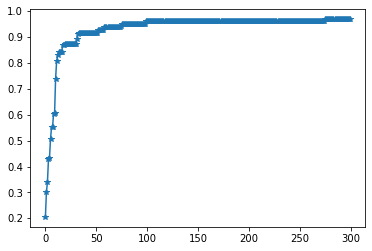

In [11]:
# training
f1_list = []
test_acc = 0 
T1 = 10
T2 = 10
epochs =300
r_sup = [range(i,i+T1) for i in range(0, epochs, int(T1 + T2))]
r_unsup = [range( i , i   + T2) for i in range(T1, epochs, int(T1 + T2))] 
r_unsup = [i for sub in r_unsup for i in sub]
r_sup = [i for sub in r_sup for i in sub]
for epoch in range(epochs ):
    print('----------------------EPOCH %d-----------------------' % epoch) 
    if epoch in r_sup:
        learn_method = 'sup'
        print('Update the Whole Graph')
        graph_stageI, classification, optimizer = apply_model(  optimizer, nodes_layers ,   dataC , 'loc', graph_stageI, classification,     b_sz,  device  , learn_method )
        max_vali_f1, test_f1 = evaluate(nodes_layers , dataC , ds, graph_stageI, classification, device,  max_vali_f1,    epoch)
    elif epoch in r_unsup:  
        print('Update only the fully connect layers')
        classification, max_vali_f1, test_f1 =train_classification( nodes_layers ,dataC , graph_stageI, classification, ds, device, max_vali_f1  )
    f1_list.append(max_vali_f1)
    if test_f1 > test_acc:
        test_acc = test_f1    
        state = {'epoch': epoch + 1, 'state_dict': [graph_stageI.state_dict(), classification.state_dict()],
             'optimizer': optimizer.state_dict() }
        torch.save(state, savepath) 
plt.plot(f1_list, '*-')      
print('max valid acc', max(f1_list))
print('test acc', test_acc)

In [12]:
# load the saved model
models, optimizer, start_epoch = load_checkpoint(models, optimizer , savebest)
graph_stageI, classification = models[0], models[1]
labels_neib = one_hot_neib(labels, neib )
models = [graph_stageI, classification]
params = []
for model in models:
    for param in model.parameters():
        if param.requires_grad:
            param.requires_grad = False
            params.append(param)

embs = graph_stageI( nodes_layers ,features)
logists =  classification(embs)
predicts = torch.max(logists, 1)[1]
labels_test = labels[ind_test] 
labels_neib_test = labels_neib[ind_test]
assert len(labels[ind_test] ) == len(predicts[ind_test]  ) 
test_f1 = f1_score(labels[ind_test] , predicts[ind_test].cpu().data, average="macro")
acc = accuracy_score(labels_test, predicts[ind_test].cpu().data)
acc_neib = hop_acc(labels_neib_test, predicts[ind_test].cpu().data)
print("Test F1:%.4f,  Acc:%.4f, Acc 1 hop: %.4f " %(test_f1, acc, acc_neib))  

=> loading checkpoint './00_saved_final/sup_33_all_21.pkl'
=> loaded checkpoint './00_saved_final/sup_33_all_21.pkl' (epoch 499)
Test F1:0.9765,  Acc:0.9779, Acc 1 hop: 0.9806 


In [7]:
# stage II parameters
A_119 = A_labels(A )
Adj = constructW_stageI(embs , logists  ,A_119, 120 )
features_X = torch.reshape(features, [features.shape[0],features.shape[1] *features.shape[2] ])
seed = 42; epochs =300
lr = 0.001
weight_decay = 5e-5
batch_size = 32
hidden = [128*3,128*3, 128*3 ]
dropout =0 
fastmode = False
np.random.seed(seed)
torch.manual_seed( seed)   
retrain2= False

In [10]:
model2 = GCN(nfeat=features_X.shape[1],
            nhid= hidden,
            nclass=119, 
            dropout= dropout)
optimizer2 = torch.optim.Adam(model2.parameters(),
                       lr= lr, weight_decay= weight_decay) 
model_name =  'StageII_all' + str(num_labelper) + '_.pkl'
newname = 'StageII_all' + str(num_labelper) + '_.pkl'
savepath2 = os.path.join(saveroot, model_name) 
savebest2 = os.path.join(saveroot, newname) 
if retrain2:
    model2.load_state_dict(torch.load(savepath2)['state_dict'] )   
    optimizer2.load_state_dict(torch.load(savepath2)['optimizer'] )   

Epoch: 0001 loss_train: 4.7916 acc_train: 0.0100 loss_val: 4.6885 acc_val: 0.0316 time: 3.0135s
Test set results: loss= 4.6847 accuracy= 0.0350 1-hop accuracy = 0.0998
Epoch: 0002 loss_train: 4.6885 acc_train: 0.0316 loss_val: 4.5963 acc_val: 0.0519 time: 2.8297s
Test set results: loss= 4.5883 accuracy= 0.0580 1-hop accuracy = 0.1076
Epoch: 0003 loss_train: 4.5963 acc_train: 0.0519 loss_val: 4.5059 acc_val: 0.0482 time: 2.8227s
Test set results: loss= 4.4942 accuracy= 0.0568 1-hop accuracy = 0.0965
Epoch: 0004 loss_train: 4.5059 acc_train: 0.0482 loss_val: 4.4127 acc_val: 0.0500 time: 2.7729s
Test set results: loss= 4.3976 accuracy= 0.0594 1-hop accuracy = 0.1065
Epoch: 0005 loss_train: 4.4127 acc_train: 0.0500 loss_val: 4.3163 acc_val: 0.0500 time: 2.9354s
Test set results: loss= 4.2985 accuracy= 0.0595 1-hop accuracy = 0.1074
Epoch: 0006 loss_train: 4.3163 acc_train: 0.0500 loss_val: 4.2187 acc_val: 0.0500 time: 2.9370s
Test set results: loss= 4.1977 accuracy= 0.0592 1-hop accuracy =

Epoch: 0050 loss_train: 2.2500 acc_train: 0.4596 loss_val: 2.2220 acc_val: 0.4609 time: 2.7763s
Test set results: loss= 2.1046 accuracy= 0.5022 1-hop accuracy = 0.6846
Epoch: 0051 loss_train: 2.2220 acc_train: 0.4609 loss_val: 2.1946 acc_val: 0.4638 time: 2.7811s
Test set results: loss= 2.0797 accuracy= 0.5060 1-hop accuracy = 0.6901
Epoch: 0052 loss_train: 2.1946 acc_train: 0.4638 loss_val: 2.1678 acc_val: 0.4655 time: 2.7970s
Test set results: loss= 2.0550 accuracy= 0.5064 1-hop accuracy = 0.6934
Epoch: 0053 loss_train: 2.1678 acc_train: 0.4655 loss_val: 2.1418 acc_val: 0.4675 time: 2.7931s
Test set results: loss= 2.0313 accuracy= 0.5078 1-hop accuracy = 0.6941
Epoch: 0054 loss_train: 2.1418 acc_train: 0.4675 loss_val: 2.1161 acc_val: 0.4716 time: 2.8242s
Test set results: loss= 2.0086 accuracy= 0.5109 1-hop accuracy = 0.6989
Epoch: 0055 loss_train: 2.1161 acc_train: 0.4716 loss_val: 2.0909 acc_val: 0.4735 time: 2.7895s
Test set results: loss= 1.9870 accuracy= 0.5139 1-hop accuracy =

Epoch: 0099 loss_train: 1.3841 acc_train: 0.6062 loss_val: 1.3726 acc_val: 0.6152 time: 2.9357s
Test set results: loss= 1.3925 accuracy= 0.6148 1-hop accuracy = 0.8524
Epoch: 0100 loss_train: 1.3726 acc_train: 0.6152 loss_val: 1.3620 acc_val: 0.6205 time: 2.9743s
Test set results: loss= 1.3855 accuracy= 0.6172 1-hop accuracy = 0.8569
Epoch: 0101 loss_train: 1.3620 acc_train: 0.6205 loss_val: 1.3529 acc_val: 0.6172 time: 2.9666s
Test set results: loss= 1.3800 accuracy= 0.6154 1-hop accuracy = 0.8585
Epoch: 0102 loss_train: 1.3529 acc_train: 0.6172 loss_val: 1.3423 acc_val: 0.6221 time: 3.0285s
Test set results: loss= 1.3709 accuracy= 0.6183 1-hop accuracy = 0.8572
Epoch: 0103 loss_train: 1.3423 acc_train: 0.6221 loss_val: 1.3315 acc_val: 0.6269 time: 2.9658s
Test set results: loss= 1.3644 accuracy= 0.6231 1-hop accuracy = 0.8638
Epoch: 0104 loss_train: 1.3315 acc_train: 0.6269 loss_val: 1.3224 acc_val: 0.6252 time: 2.9534s
Test set results: loss= 1.3600 accuracy= 0.6199 1-hop accuracy =

Epoch: 0148 loss_train: 1.0240 acc_train: 0.6968 loss_val: 1.0185 acc_val: 0.6949 time: 3.2523s
Test set results: loss= 1.1903 accuracy= 0.6658 1-hop accuracy = 0.9337
Epoch: 0149 loss_train: 1.0185 acc_train: 0.6949 loss_val: 1.0146 acc_val: 0.6914 time: 3.1884s
Test set results: loss= 1.1890 accuracy= 0.6641 1-hop accuracy = 0.9306
Epoch: 0150 loss_train: 1.0146 acc_train: 0.6914 loss_val: 1.0098 acc_val: 0.6989 time: 3.2090s
Test set results: loss= 1.1831 accuracy= 0.6730 1-hop accuracy = 0.9416
Epoch: 0151 loss_train: 1.0098 acc_train: 0.6989 loss_val: 1.0043 acc_val: 0.6958 time: 3.2282s
Test set results: loss= 1.1845 accuracy= 0.6672 1-hop accuracy = 0.9350
Epoch: 0152 loss_train: 1.0043 acc_train: 0.6958 loss_val: 1.0001 acc_val: 0.6986 time: 3.2360s
Test set results: loss= 1.1830 accuracy= 0.6664 1-hop accuracy = 0.9355
Epoch: 0153 loss_train: 1.0001 acc_train: 0.6986 loss_val: 0.9959 acc_val: 0.7004 time: 3.2116s
Test set results: loss= 1.1778 accuracy= 0.6762 1-hop accuracy =

Epoch: 0197 loss_train: 0.8439 acc_train: 0.7215 loss_val: 0.8412 acc_val: 0.7249 time: 3.3412s
Test set results: loss= 1.1295 accuracy= 0.6958 1-hop accuracy = 0.9629
Epoch: 0198 loss_train: 0.8412 acc_train: 0.7249 loss_val: 0.8386 acc_val: 0.7239 time: 3.3093s
Test set results: loss= 1.1289 accuracy= 0.6940 1-hop accuracy = 0.9596
Epoch: 0199 loss_train: 0.8386 acc_train: 0.7239 loss_val: 0.8358 acc_val: 0.7264 time: 3.3098s
Test set results: loss= 1.1289 accuracy= 0.6972 1-hop accuracy = 0.9633
Epoch: 0200 loss_train: 0.8358 acc_train: 0.7264 loss_val: 0.8332 acc_val: 0.7243 time: 3.3061s
Test set results: loss= 1.1265 accuracy= 0.6955 1-hop accuracy = 0.9626
Epoch: 0201 loss_train: 0.8332 acc_train: 0.7243 loss_val: 0.8306 acc_val: 0.7264 time: 3.3078s
Test set results: loss= 1.1293 accuracy= 0.6954 1-hop accuracy = 0.9619
Epoch: 0202 loss_train: 0.8306 acc_train: 0.7264 loss_val: 0.8281 acc_val: 0.7269 time: 3.2950s
Test set results: loss= 1.1258 accuracy= 0.6959 1-hop accuracy =

Epoch: 0246 loss_train: 0.7424 acc_train: 0.7431 loss_val: 0.7409 acc_val: 0.7394 time: 3.3536s
Test set results: loss= 1.1258 accuracy= 0.6962 1-hop accuracy = 0.9609
Epoch: 0247 loss_train: 0.7409 acc_train: 0.7394 loss_val: 0.7390 acc_val: 0.7408 time: 3.3552s
Test set results: loss= 1.1246 accuracy= 0.6963 1-hop accuracy = 0.9629
Epoch: 0248 loss_train: 0.7390 acc_train: 0.7408 loss_val: 0.7373 acc_val: 0.7400 time: 3.3431s
Test set results: loss= 1.1283 accuracy= 0.6950 1-hop accuracy = 0.9605
Epoch: 0249 loss_train: 0.7373 acc_train: 0.7400 loss_val: 0.7360 acc_val: 0.7392 time: 3.3314s
Test set results: loss= 1.1226 accuracy= 0.6969 1-hop accuracy = 0.9620
Epoch: 0250 loss_train: 0.7360 acc_train: 0.7392 loss_val: 0.7349 acc_val: 0.7422 time: 3.3618s
Test set results: loss= 1.1318 accuracy= 0.6944 1-hop accuracy = 0.9597
Epoch: 0251 loss_train: 0.7349 acc_train: 0.7422 loss_val: 0.7339 acc_val: 0.7381 time: 3.3420s
Test set results: loss= 1.1220 accuracy= 0.6979 1-hop accuracy =

Epoch: 0295 loss_train: 0.6782 acc_train: 0.7511 loss_val: 0.6778 acc_val: 0.7538 time: 3.4276s
Test set results: loss= 1.1468 accuracy= 0.6981 1-hop accuracy = 0.9643
Epoch: 0296 loss_train: 0.6778 acc_train: 0.7538 loss_val: 0.6776 acc_val: 0.7536 time: 3.4259s
Test set results: loss= 1.1497 accuracy= 0.6953 1-hop accuracy = 0.9613
Epoch: 0297 loss_train: 0.6776 acc_train: 0.7536 loss_val: 0.6760 acc_val: 0.7485 time: 3.5029s
Test set results: loss= 1.1484 accuracy= 0.6993 1-hop accuracy = 0.9627
Epoch: 0298 loss_train: 0.6760 acc_train: 0.7485 loss_val: 0.6740 acc_val: 0.7553 time: 3.4243s
Test set results: loss= 1.1485 accuracy= 0.6961 1-hop accuracy = 0.9604
Epoch: 0299 loss_train: 0.6740 acc_train: 0.7553 loss_val: 0.6728 acc_val: 0.7502 time: 3.4089s
Test set results: loss= 1.1501 accuracy= 0.6967 1-hop accuracy = 0.9620
Epoch: 0300 loss_train: 0.6728 acc_train: 0.7502 loss_val: 0.6720 acc_val: 0.7571 time: 3.4711s
Test set results: loss= 1.1496 accuracy= 0.6967 1-hop accuracy =

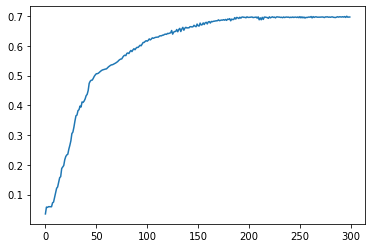

In [14]:
# Train model  
t_total = time.time()
acc_epoch = []
best_acc = 0
start = time.time()
for epoch in range(300):  
    acc_train = train( epoch, model2,optimizer2,  features_X    , labels   , Adj, ind_train, fastmode, ind_train, batch_size)
    acc_test, acc_hop = test(model2, features_X , labels ,A_119, Adj, ind_test)
    acc_epoch.append(acc_test.numpy())
    if acc_test.numpy() > best_acc:
        best_acc = acc_test.numpy() 
        state = {'epoch': epoch + 1, 'state_dict': model2.state_dict() ,
             'optimizer': optimizer2.state_dict() }
        torch.save(state, savepath2)
print("Optimization Finished!") 
print('The max acc is %.4f' %np.max(acc_epoch))  
print('The test max acc is %.4f' %np.max(acc_epoch))
print('The test argmax acc is %2d' %np.argmax(acc_epoch)) 